# Regression ANN with best parameters
    find the best prediction window to apply with a rolling Nested CV technique

In [1]:
import pandas as pd;
import numpy as np;
import sklearn
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict;
from sklearn.preprocessing import MinMaxScaler;
from sklearn import metrics;
from sklearn.model_selection import TimeSeriesSplit;

dates = [2018080000, 
         2018090000,
         2018100000, 
         2018110000, 
         2018120000]

dates_labels = ['1', 
                '2 ',
                '3 ',  
                '4 ', 
                '5 ']

mae_cv = []
mse_cv = []
mae_gen = []
mse_gen  =[]
rmse_gen = []
mae_nor = []
mae_spi = []
mse_nor = []
mse_spi = []
rmse_nor = []
rmse_spi = []

# Loop with model for 8 different data ranges (3 months intervals):

In [2]:
for i in dates:
    count = 0
    # data
    data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)
    data = data.loc[data.index > i, :]
    
    # reset index
    data.reset_index(inplace = True)
    data.drop('index', axis = 1, inplace = True)
    
    # Divide features and labels
    X = data.iloc[:, 0:15]
    y = data.loc[:, 'Offers']
    
    X.fillna(method = 'ffill', inplace = True)
    y.fillna(method = 'ffill', inplace = True)
    
    X = X.astype('float64')
    X = X.round(20)
    
    # divide data into train and test with 20% test data
    X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size=0.1, shuffle=False)
    
    # feature scaling
    sc_X = MinMaxScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    
    import keras
    from keras.models import Sequential # to initialise the NN
    from keras.layers import Dense # to create layers
    from keras.layers import Dropout
    from keras import initializers
    from keras import optimizers
    from keras.wrappers.scikit_learn import KerasRegressor
    
    # possible debug
    X_train = np.nan_to_num(X_train)
    X_test = np.nan_to_num(X_test)
    
    def regressor_tunning(n_hidden = 5, 
                          n_neurons = 40, 
                          kernel_initializer = "he_normal",
                          bias_initializer = initializers.Ones()):
        model = Sequential()
        model.add(Dense(units = n_neurons, input_dim = 15))
        model.add(keras.layers.LeakyReLU(alpha = 0.2))
        model.add(Dropout(rate = 0.1))
        for layer in range(n_hidden):
            model.add(Dense(n_neurons))
            model.add(keras.layers.LeakyReLU(alpha = 0.2))
            model.add(Dropout(rate = 0.1))
        model.add(Dense(units = 1, activation = 'linear'))
        optimizer = optimizers.Adamax(lr = 0.001)
        model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mse', 'mae'])
        return model
    
    tscv = TimeSeriesSplit(n_splits = 10)
    
    hist_list = pd.DataFrame()
    count = 1
    
    regressor = regressor_tunning()
    
    for train_index, test_index in tscv.split(X_train):
          X_train_split, X_test_split = X_train[train_index], X_train[test_index]
          y_train_split, y_test_split = y_train[train_index], y_train[test_index]
          hist = regressor.fit(X_train_split, y_train_split, batch_size = 15, epochs = 100)
          hist_list = hist_list.append(hist.history, ignore_index = True)
          print(count)
          count = count + 1

    a = []
    b = []
    
    for i in range(len(hist_list.mse)):
        a.append(np.mean(hist_list.mse[i]))
        b.append(np.mean(hist_list.mae[i]))
      
    mse_cv.append(np.mean(a))
    mae_cv.append(np.mean(b))
    
    # predict for X_test  
    y_pred = regressor.predict(X_test)

    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mse_error = mse(y_test, y_pred) # 1479.61335
    mae_error = mae(y_test, y_pred) # 23.1525
    
    rmse_gen.append(rmse_error)
    mse_gen.append(mse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])
    
    # create array same size as y_test
    y_spike_occ = y_spike_occ.iloc[- len(y_test):]
    y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values
    
    
    # smal adjustment
    y_test.replace(0, 0.0001,inplace = True)

    
    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mse_spike = mse(y_test_spike, y_pred_spike)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mse_spi.append(mse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mse_normal = mse(y_test_normal, y_pred_normal)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mse_nor.append(mse_normal)
    mae_nor.append(mae_normal)

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
41/41 [==============================] - 0s 1ms/step - loss: 11265.8105 - mse: 11265.8105 - mae: 99.6931
Epoch 2/100
41/41 [==============================] - 0s 1ms/step - loss: 9183.0908 - mse: 9183.0908 - mae: 88.3996
Epoch 3/100
41/41 [==============================] - 0s 1ms/step - loss: 3097.7834 - mse: 3097.7834 - mae: 40.7947
Epoch 4/100
41/41 [==============================] - 0s 1ms/step - loss: 1719.1091 - mse: 1719.1093 - mae: 26.6520
Epoch 5/100
41/41 [==============================] - 0s 827us/step - loss: 1813.8922 - mse: 1813.8922 - mae: 27.5091
Epoch 6/100
41/41 [==============================] - 0s 827us/step - loss: 1791.0671 - mse: 1791.0671 - mae: 27.2289
Epoch 7/100
41/41 [==============================] - 0s 851us/step - loss: 1748.6478 - mse: 1748.6478 - mae: 27.0034
Epoch 8/100
41/41 [==============================] - 0s 827us/step - loss: 1649.6897 - mse: 1649.6897 - mae: 27.2723
Epoch 9/100
41/41 [==============================] - 0s 778us/step - l

41/41 [==============================] - 0s 997us/step - loss: 1573.5269 - mse: 1573.5269 - mae: 25.3228
Epoch 71/100
41/41 [==============================] - 0s 803us/step - loss: 1547.7837 - mse: 1547.7837 - mae: 24.6536
Epoch 72/100
41/41 [==============================] - 0s 803us/step - loss: 1567.6685 - mse: 1567.6685 - mae: 24.5087
Epoch 73/100
41/41 [==============================] - 0s 754us/step - loss: 1502.8685 - mse: 1502.8685 - mae: 24.2606
Epoch 74/100
41/41 [==============================] - 0s 778us/step - loss: 1569.9680 - mse: 1569.9680 - mae: 24.5010
Epoch 75/100
41/41 [==============================] - 0s 754us/step - loss: 1572.8073 - mse: 1572.8073 - mae: 25.2171
Epoch 76/100
41/41 [==============================] - 0s 754us/step - loss: 1628.5891 - mse: 1628.5891 - mae: 25.3733
Epoch 77/100
41/41 [==============================] - 0s 900us/step - loss: 1552.9587 - mse: 1552.9587 - mae: 24.4597
Epoch 78/100
41/41 [==============================] - 0s 754us/step -

81/81 [==============================] - 0s 850us/step - loss: 2085.0139 - mse: 2085.0139 - mae: 29.6864
Epoch 40/100
81/81 [==============================] - 0s 881us/step - loss: 1982.7542 - mse: 1982.7542 - mae: 28.9707
Epoch 41/100
81/81 [==============================] - 0s 825us/step - loss: 2058.8035 - mse: 2058.8035 - mae: 29.5097
Epoch 42/100
81/81 [==============================] - 0s 855us/step - loss: 1995.5630 - mse: 1995.5630 - mae: 29.0139
Epoch 43/100
81/81 [==============================] - 0s 788us/step - loss: 1991.6366 - mse: 1991.6366 - mae: 29.2555
Epoch 44/100
81/81 [==============================] - 0s 1ms/step - loss: 1923.0824 - mse: 1923.0824 - mae: 28.9840
Epoch 45/100
81/81 [==============================] - 0s 2ms/step - loss: 1979.8995 - mse: 1979.8995 - mae: 28.5802
Epoch 46/100
81/81 [==============================] - 0s 1ms/step - loss: 1995.8912 - mse: 1995.8912 - mae: 29.2135
Epoch 47/100
81/81 [==============================] - 0s 973us/step - loss:

121/121 [==============================] - 0s 791us/step - loss: 1716.9012 - mse: 1716.9012 - mae: 27.0013
Epoch 9/100
121/121 [==============================] - 0s 767us/step - loss: 1712.0793 - mse: 1712.0793 - mae: 27.7110
Epoch 10/100
121/121 [==============================] - 0s 764us/step - loss: 1755.6837 - mse: 1755.6837 - mae: 27.4872
Epoch 11/100
121/121 [==============================] - 0s 809us/step - loss: 1697.4657 - mse: 1697.4657 - mae: 26.9720
Epoch 12/100
121/121 [==============================] - 0s 806us/step - loss: 1674.7906 - mse: 1674.7906 - mae: 27.0518
Epoch 13/100
121/121 [==============================] - 0s 1ms/step - loss: 1722.4882 - mse: 1722.4882 - mae: 27.7039
Epoch 14/100
121/121 [==============================] - 0s 1ms/step - loss: 1718.6562 - mse: 1718.6562 - mae: 27.6811
Epoch 15/100
121/121 [==============================] - 0s 1ms/step - loss: 1717.2263 - mse: 1717.2263 - mae: 27.2514
Epoch 16/100
121/121 [==============================] - 0s 1

121/121 [==============================] - 0s 883us/step - loss: 1631.6432 - mse: 1631.6432 - mae: 26.4932
Epoch 77/100
121/121 [==============================] - 0s 1ms/step - loss: 1654.3234 - mse: 1654.3234 - mae: 26.6098
Epoch 78/100
121/121 [==============================] - 0s 1ms/step - loss: 1566.8192 - mse: 1566.8192 - mae: 25.8568
Epoch 79/100
121/121 [==============================] - 0s 997us/step - loss: 1628.5723 - mse: 1628.5723 - mae: 26.2290
Epoch 80/100
121/121 [==============================] - 0s 997us/step - loss: 1604.2661 - mse: 1604.2661 - mae: 26.4575
Epoch 81/100
121/121 [==============================] - 0s 816us/step - loss: 1600.7725 - mse: 1600.7725 - mae: 26.5308
Epoch 82/100
121/121 [==============================] - 0s 824us/step - loss: 1623.0111 - mse: 1623.0111 - mae: 26.3382
Epoch 83/100
121/121 [==============================] - 0s 808us/step - loss: 1625.1665 - mse: 1625.1665 - mae: 26.5673
Epoch 84/100
121/121 [==============================] - 0

161/161 [==============================] - 0s 1ms/step - loss: 2400.0293 - mse: 2400.0293 - mae: 27.2744
Epoch 45/100
161/161 [==============================] - 0s 995us/step - loss: 2392.1555 - mse: 2392.1555 - mae: 26.9283
Epoch 46/100
161/161 [==============================] - 0s 1ms/step - loss: 2413.2449 - mse: 2413.2449 - mae: 26.8938
Epoch 47/100
161/161 [==============================] - 0s 1ms/step - loss: 2372.0725 - mse: 2372.0725 - mae: 26.7942
Epoch 48/100
161/161 [==============================] - 0s 1ms/step - loss: 2422.3923 - mse: 2422.3921 - mae: 27.0964
Epoch 49/100
161/161 [==============================] - 0s 926us/step - loss: 2376.8267 - mse: 2376.8267 - mae: 26.4694
Epoch 50/100
161/161 [==============================] - 0s 1ms/step - loss: 2411.5767 - mse: 2411.5767 - mae: 26.7330
Epoch 51/100
161/161 [==============================] - 0s 1ms/step - loss: 2356.4441 - mse: 2356.4441 - mae: 26.5355
Epoch 52/100
161/161 [==============================] - 0s 1ms/st

201/201 [==============================] - ETA: 0s - loss: 1558.4778 - mse: 1558.4778 - mae: 26.19 - 0s 1ms/step - loss: 2195.3018 - mse: 2195.3018 - mae: 26.6357
Epoch 14/100
201/201 [==============================] - 0s 1ms/step - loss: 2179.5947 - mse: 2179.5947 - mae: 26.5979
Epoch 15/100
201/201 [==============================] - 0s 1ms/step - loss: 2162.8398 - mse: 2162.8398 - mae: 26.3866
Epoch 16/100
201/201 [==============================] - 0s 1ms/step - loss: 2204.9131 - mse: 2204.9131 - mae: 26.7104
Epoch 17/100
201/201 [==============================] - 0s 1ms/step - loss: 2155.3777 - mse: 2155.3777 - mae: 26.2013
Epoch 18/100
201/201 [==============================] - 0s 1ms/step - loss: 2187.6416 - mse: 2187.6416 - mae: 26.7236
Epoch 19/100
201/201 [==============================] - 0s 1ms/step - loss: 2218.9617 - mse: 2218.9617 - mae: 26.8182
Epoch 20/100
201/201 [==============================] - 0s 1ms/step - loss: 2223.7810 - mse: 2223.7808 - mae: 26.7143
Epoch 21/10

201/201 [==============================] - 0s 1ms/step - loss: 2112.6602 - mse: 2112.6602 - mae: 25.9798
Epoch 83/100
201/201 [==============================] - 0s 1ms/step - loss: 2145.8306 - mse: 2145.8306 - mae: 26.4164
Epoch 84/100
201/201 [==============================] - 0s 1ms/step - loss: 2132.9089 - mse: 2132.9089 - mae: 26.1345
Epoch 85/100
201/201 [==============================] - 0s 1ms/step - loss: 2136.1982 - mse: 2136.1982 - mae: 25.7071
Epoch 86/100
201/201 [==============================] - 0s 1ms/step - loss: 2120.3052 - mse: 2120.3052 - mae: 26.1223
Epoch 87/100
201/201 [==============================] - 0s 1ms/step - loss: 2163.2034 - mse: 2163.2034 - mae: 26.3647
Epoch 88/100
201/201 [==============================] - 0s 1ms/step - loss: 2128.7761 - mse: 2128.7761 - mae: 26.0727
Epoch 89/100
201/201 [==============================] - 0s 1ms/step - loss: 2136.4739 - mse: 2136.4739 - mae: 25.8872
Epoch 90/100
201/201 [==============================] - 0s 1ms/step -

241/241 [==============================] - 0s 1ms/step - loss: 2001.8372 - mse: 2001.8372 - mae: 25.5636
Epoch 52/100
241/241 [==============================] - 0s 1ms/step - loss: 2017.0192 - mse: 2017.0192 - mae: 25.9800
Epoch 53/100
241/241 [==============================] - 0s 1ms/step - loss: 1981.7120 - mse: 1981.7120 - mae: 25.6553
Epoch 54/100
241/241 [==============================] - 0s 1ms/step - loss: 1987.7562 - mse: 1987.7562 - mae: 25.6640
Epoch 55/100
241/241 [==============================] - 0s 1ms/step - loss: 2023.3582 - mse: 2023.3582 - mae: 25.9319
Epoch 56/100
241/241 [==============================] - 0s 1ms/step - loss: 1989.9529 - mse: 1989.9529 - mae: 25.7825
Epoch 57/100
241/241 [==============================] - 0s 1ms/step - loss: 2016.7100 - mse: 2016.7100 - mae: 25.7645
Epoch 58/100
241/241 [==============================] - 0s 962us/step - loss: 2015.3156 - mse: 2015.3156 - mae: 25.7848
Epoch 59/100
241/241 [==============================] - 0s 2ms/step

281/281 [==============================] - 0s 986us/step - loss: 1883.6942 - mse: 1883.6942 - mae: 25.4403
Epoch 21/100
281/281 [==============================] - 0s 939us/step - loss: 1841.7843 - mse: 1841.7843 - mae: 25.2163
Epoch 22/100
281/281 [==============================] - 0s 965us/step - loss: 1871.5494 - mse: 1871.5494 - mae: 25.5208
Epoch 23/100
281/281 [==============================] - 0s 1ms/step - loss: 1868.2502 - mse: 1868.2502 - mae: 25.5172
Epoch 24/100
281/281 [==============================] - 0s 1ms/step - loss: 1842.6118 - mse: 1842.6118 - mae: 25.4743
Epoch 25/100
281/281 [==============================] - 0s 1ms/step - loss: 1861.6631 - mse: 1861.6633 - mae: 25.3352
Epoch 26/100
281/281 [==============================] - 0s 2ms/step - loss: 1852.1132 - mse: 1852.1132 - mae: 25.1386
Epoch 27/100
281/281 [==============================] - 1s 2ms/step - loss: 1858.8309 - mse: 1858.8309 - mae: 25.2862
Epoch 28/100
281/281 [==============================] - 0s 1ms/

281/281 [==============================] - 0s 892us/step - loss: 1813.4119 - mse: 1813.4119 - mae: 24.7957
Epoch 89/100
281/281 [==============================] - 0s 969us/step - loss: 1823.3188 - mse: 1823.3188 - mae: 24.8875
Epoch 90/100
281/281 [==============================] - 0s 1ms/step - loss: 1814.2758 - mse: 1814.2758 - mae: 24.9232
Epoch 91/100
281/281 [==============================] - 0s 1ms/step - loss: 1815.7374 - mse: 1815.7374 - mae: 24.7761
Epoch 92/100
281/281 [==============================] - 0s 1ms/step - loss: 1804.3284 - mse: 1804.3286 - mae: 24.8765
Epoch 93/100
281/281 [==============================] - 0s 1ms/step - loss: 1797.3807 - mse: 1797.3807 - mae: 24.7933
Epoch 94/100
281/281 [==============================] - 0s 978us/step - loss: 1807.4794 - mse: 1807.4794 - mae: 24.8176
Epoch 95/100
281/281 [==============================] - 0s 924us/step - loss: 1818.1464 - mse: 1818.1464 - mae: 24.9651
Epoch 96/100
281/281 [==============================] - 0s 1m

321/321 [==============================] - 0s 1ms/step - loss: 2164.4900 - mse: 2164.4900 - mae: 25.6316
Epoch 58/100
321/321 [==============================] - 1s 2ms/step - loss: 2163.5840 - mse: 2163.5840 - mae: 25.5554
Epoch 59/100
321/321 [==============================] - 0s 1ms/step - loss: 2143.5474 - mse: 2143.5474 - mae: 25.4448
Epoch 60/100
321/321 [==============================] - 0s 1ms/step - loss: 2148.0105 - mse: 2148.0105 - mae: 25.4491
Epoch 61/100
321/321 [==============================] - 0s 1ms/step - loss: 2150.0098 - mse: 2150.0098 - mae: 25.4441
Epoch 62/100
321/321 [==============================] - 0s 1ms/step - loss: 2139.3076 - mse: 2139.3076 - mae: 25.2301
Epoch 63/100
321/321 [==============================] - 0s 1ms/step - loss: 2175.4854 - mse: 2175.4854 - mae: 25.6392
Epoch 64/100
321/321 [==============================] - 0s 970us/step - loss: 2184.1777 - mse: 2184.1777 - mae: 25.4750
Epoch 65/100
321/321 [==============================] - 0s 1ms/step

361/361 [==============================] - 0s 1ms/step - loss: 2068.4185 - mse: 2068.4185 - mae: 25.2527
Epoch 27/100
361/361 [==============================] - 0s 1ms/step - loss: 2068.5525 - mse: 2068.5525 - mae: 25.3608
Epoch 28/100
361/361 [==============================] - 0s 1ms/step - loss: 2067.6379 - mse: 2067.6379 - mae: 25.4011
Epoch 29/100
361/361 [==============================] - 0s 1ms/step - loss: 2040.8730 - mse: 2040.8730 - mae: 25.0058
Epoch 30/100
361/361 [==============================] - 0s 1ms/step - loss: 2068.7939 - mse: 2068.7939 - mae: 25.2134
Epoch 31/100
361/361 [==============================] - 0s 1ms/step - loss: 2078.9187 - mse: 2078.9187 - mae: 25.2234
Epoch 32/100
361/361 [==============================] - 0s 1ms/step - loss: 2076.8691 - mse: 2076.8691 - mae: 25.2028
Epoch 33/100
361/361 [==============================] - 1s 1ms/step - loss: 2051.4685 - mse: 2051.4685 - mae: 25.1856
Epoch 34/100
361/361 [==============================] - 0s 1ms/step -

361/361 [==============================] - 0s 1ms/step - loss: 2018.0231 - mse: 2018.0231 - mae: 24.7236
Epoch 96/100
361/361 [==============================] - 0s 1ms/step - loss: 2018.5308 - mse: 2018.5308 - mae: 24.8277
Epoch 97/100
361/361 [==============================] - 0s 1ms/step - loss: 2004.1394 - mse: 2004.1394 - mae: 24.9165
Epoch 98/100
361/361 [==============================] - 0s 1ms/step - loss: 2008.5867 - mse: 2008.5867 - mae: 24.7823
Epoch 99/100
361/361 [==============================] - 0s 1ms/step - loss: 2011.7880 - mse: 2011.7880 - mae: 24.7245
Epoch 100/100
361/361 [==============================] - 0s 985us/step - loss: 2033.0237 - mse: 2033.0237 - mae: 24.9748
9
Epoch 1/100
401/401 [==============================] - 0s 1ms/step - loss: 2131.1213 - mse: 2131.1213 - mae: 25.2979
Epoch 2/100
401/401 [==============================] - 0s 1ms/step - loss: 2116.9648 - mse: 2116.9648 - mae: 25.5206
Epoch 3/100
401/401 [==============================] - 0s 1ms/step

401/401 [==============================] - 0s 1ms/step - loss: 2037.2439 - mse: 2037.2439 - mae: 25.0866
Epoch 65/100
401/401 [==============================] - 1s 1ms/step - loss: 2046.5959 - mse: 2046.5959 - mae: 24.7077
Epoch 66/100
401/401 [==============================] - 1s 1ms/step - loss: 2051.4329 - mse: 2051.4329 - mae: 25.1232
Epoch 67/100
401/401 [==============================] - 0s 1ms/step - loss: 2057.0862 - mse: 2057.0862 - mae: 25.1717
Epoch 68/100
401/401 [==============================] - 1s 1ms/step - loss: 2048.2817 - mse: 2048.2817 - mae: 24.7902
Epoch 69/100
401/401 [==============================] - 0s 1ms/step - loss: 2038.9261 - mse: 2038.9261 - mae: 24.9928
Epoch 70/100
401/401 [==============================] - 0s 1ms/step - loss: 2038.1890 - mse: 2038.1890 - mae: 24.8659
Epoch 71/100
401/401 [==============================] - 0s 1ms/step - loss: 2056.5845 - mse: 2056.5845 - mae: 24.9938
Epoch 72/100
401/401 [==============================] - 0s 953us/step

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
33/33 [==============================] - 0s 967us/step - loss: 13415.8867 - mse: 13415.8867 - mae: 110.0111
Epoch 2/100
33/33 [==============================] - 0s 984us/step - loss: 12975.1211 - mse: 12975.1211 - mae: 107.9994
Epoch 3/100
33/33 [==============================] - 0s 876us/step - loss: 10859.0820 - mse: 10859.0820 - mae: 97.4264
Epoch 4/100
33/33 [==============================] - 0s 937us/step - loss: 4754.0312 - mse: 4754.0312 - mae: 54.7339
Epoch 5/100
33/33 [==============================] - 0s 937us/step - loss: 1930.3187 - mse: 1930.3187 - mae: 29.4267
Epoch 6/100
33/33 [==============================] - 0s 1ms/step - loss: 1829.3917 - mse: 1829.3917 - mae: 28.5219
Epoch 7/100
33/33 [==============================] - 0s 1ms/step - loss: 1882.6465 - mse: 1882.6465 - mae: 28.6411
Epoch 8/100
33/33 [==============================] - 0s 1ms/step - loss: 1650.0449 - mse: 1650.0449 - mae: 26.7438
Epoch 9/100
33/33 [==============================] - 0s 1ms/st

33/33 [==============================] - 0s 1ms/step - loss: 1627.7603 - mse: 1627.7603 - mae: 26.8762
Epoch 72/100
33/33 [==============================] - 0s 967us/step - loss: 1682.2284 - mse: 1682.2284 - mae: 26.4302
Epoch 73/100
33/33 [==============================] - 0s 966us/step - loss: 1580.4371 - mse: 1580.4371 - mae: 26.2169
Epoch 74/100
33/33 [==============================] - 0s 1ms/step - loss: 1604.0879 - mse: 1604.0879 - mae: 26.3318
Epoch 75/100
33/33 [==============================] - 0s 1ms/step - loss: 1571.2432 - mse: 1571.2432 - mae: 24.8624
Epoch 76/100
33/33 [==============================] - 0s 1ms/step - loss: 1589.3632 - mse: 1589.3632 - mae: 26.5076
Epoch 77/100
33/33 [==============================] - 0s 1ms/step - loss: 1497.0415 - mse: 1497.0415 - mae: 25.3515
Epoch 78/100
33/33 [==============================] - 0s 972us/step - loss: 1598.6964 - mse: 1598.6964 - mae: 26.3720
Epoch 79/100
33/33 [==============================] - 0s 1ms/step - loss: 1615.

65/65 [==============================] - 0s 1ms/step - loss: 3857.3123 - mse: 3857.3127 - mae: 30.4374
Epoch 42/100
65/65 [==============================] - 0s 988us/step - loss: 3740.7861 - mse: 3740.7861 - mae: 29.5292
Epoch 43/100
65/65 [==============================] - 0s 931us/step - loss: 3744.4858 - mse: 3744.4858 - mae: 29.5480
Epoch 44/100
65/65 [==============================] - 0s 910us/step - loss: 3695.7854 - mse: 3695.7854 - mae: 29.4238
Epoch 45/100
65/65 [==============================] - 0s 1ms/step - loss: 3758.1296 - mse: 3758.1296 - mae: 30.5280
Epoch 46/100
65/65 [==============================] - 0s 1ms/step - loss: 3661.5620 - mse: 3661.5620 - mae: 29.2960
Epoch 47/100
65/65 [==============================] - 0s 1ms/step - loss: 3718.6641 - mse: 3718.6641 - mae: 29.8761
Epoch 48/100
65/65 [==============================] - 0s 1ms/step - loss: 3657.2314 - mse: 3657.2314 - mae: 30.1812
Epoch 49/100
65/65 [==============================] - 0s 1ms/step - loss: 3710.

96/96 [==============================] - 0s 962us/step - loss: 3069.6289 - mse: 3069.6289 - mae: 28.8760
Epoch 12/100
96/96 [==============================] - 0s 945us/step - loss: 3002.3682 - mse: 3002.3682 - mae: 28.7681
Epoch 13/100
96/96 [==============================] - 0s 1ms/step - loss: 2979.6643 - mse: 2979.6643 - mae: 28.5122
Epoch 14/100
96/96 [==============================] - 0s 1ms/step - loss: 3086.9299 - mse: 3086.9299 - mae: 29.7483
Epoch 15/100
96/96 [==============================] - 0s 1ms/step - loss: 3042.5627 - mse: 3042.5627 - mae: 29.0528
Epoch 16/100
96/96 [==============================] - 0s 1ms/step - loss: 3084.6350 - mse: 3084.6350 - mae: 29.4462
Epoch 17/100
96/96 [==============================] - 0s 1ms/step - loss: 2954.0750 - mse: 2954.0750 - mae: 28.8346
Epoch 18/100
96/96 [==============================] - 0s 1ms/step - loss: 2961.1965 - mse: 2961.1965 - mae: 28.2039
Epoch 19/100
96/96 [==============================] - 0s 1ms/step - loss: 3001.75

96/96 [==============================] - 0s 1ms/step - loss: 2923.2893 - mse: 2923.2893 - mae: 27.9237
Epoch 82/100
96/96 [==============================] - 0s 1ms/step - loss: 2945.7844 - mse: 2945.7844 - mae: 28.8958
Epoch 83/100
96/96 [==============================] - 0s 1ms/step - loss: 2911.2087 - mse: 2911.2087 - mae: 27.9286
Epoch 84/100
96/96 [==============================] - 0s 1ms/step - loss: 2950.8865 - mse: 2950.8865 - mae: 28.7910
Epoch 85/100
96/96 [==============================] - 0s 1ms/step - loss: 2896.8003 - mse: 2896.8003 - mae: 28.0375
Epoch 86/100
96/96 [==============================] - 0s 1ms/step - loss: 2928.5647 - mse: 2928.5647 - mae: 28.2139
Epoch 87/100
96/96 [==============================] - 0s 1ms/step - loss: 2957.8135 - mse: 2957.8135 - mae: 28.4364
Epoch 88/100
96/96 [==============================] - 0s 1ms/step - loss: 2933.6206 - mse: 2933.6206 - mae: 28.2817
Epoch 89/100
96/96 [==============================] - 0s 1ms/step - loss: 2933.4336 -

128/128 [==============================] - 0s 1ms/step - loss: 2601.2922 - mse: 2601.2922 - mae: 27.8310
Epoch 51/100
128/128 [==============================] - 0s 1ms/step - loss: 2570.7290 - mse: 2570.7290 - mae: 27.4900
Epoch 52/100
128/128 [==============================] - 0s 1ms/step - loss: 2596.4656 - mse: 2596.4656 - mae: 27.7139
Epoch 53/100
128/128 [==============================] - 0s 1ms/step - loss: 2611.2544 - mse: 2611.2544 - mae: 27.4003
Epoch 54/100
128/128 [==============================] - 0s 1ms/step - loss: 2576.3806 - mse: 2576.3806 - mae: 27.8639
Epoch 55/100
128/128 [==============================] - 0s 1ms/step - loss: 2530.3481 - mse: 2530.3481 - mae: 27.4102
Epoch 56/100
128/128 [==============================] - 0s 1ms/step - loss: 2578.9355 - mse: 2578.9355 - mae: 27.9509
Epoch 57/100
128/128 [==============================] - 0s 1ms/step - loss: 2566.0967 - mse: 2566.0967 - mae: 27.8615
Epoch 58/100
128/128 [==============================] - 0s 1ms/step -

160/160 [==============================] - 0s 1ms/step - loss: 2298.5786 - mse: 2298.5786 - mae: 27.0159
Epoch 20/100
160/160 [==============================] - 0s 2ms/step - loss: 2254.2720 - mse: 2254.2720 - mae: 26.8241
Epoch 21/100
160/160 [==============================] - 0s 2ms/step - loss: 2343.3159 - mse: 2343.3159 - mae: 27.3287
Epoch 22/100
160/160 [==============================] - 0s 2ms/step - loss: 2323.8308 - mse: 2323.8308 - mae: 27.2616
Epoch 23/100
160/160 [==============================] - 0s 1ms/step - loss: 2259.0278 - mse: 2259.0278 - mae: 27.2403
Epoch 24/100
160/160 [==============================] - 0s 2ms/step - loss: 2327.8401 - mse: 2327.8396 - mae: 27.5070
Epoch 25/100
160/160 [==============================] - 0s 1ms/step - loss: 2324.1187 - mse: 2324.1187 - mae: 27.1966
Epoch 26/100
160/160 [==============================] - 0s 2ms/step - loss: 2328.8354 - mse: 2328.8354 - mae: 27.6282
Epoch 27/100
160/160 [==============================] - 0s 2ms/step -

160/160 [==============================] - 0s 2ms/step - loss: 2286.6865 - mse: 2286.6865 - mae: 26.7268
Epoch 89/100
160/160 [==============================] - 0s 2ms/step - loss: 2276.1792 - mse: 2276.1792 - mae: 26.9689
Epoch 90/100
160/160 [==============================] - 0s 2ms/step - loss: 2232.4170 - mse: 2232.4170 - mae: 26.6476
Epoch 91/100
160/160 [==============================] - 0s 2ms/step - loss: 2283.8528 - mse: 2283.8528 - mae: 26.9990
Epoch 92/100
160/160 [==============================] - 0s 2ms/step - loss: 2272.2749 - mse: 2272.2749 - mae: 26.5884
Epoch 93/100
160/160 [==============================] - 0s 2ms/step - loss: 2278.2488 - mse: 2278.2488 - mae: 26.8014
Epoch 94/100
160/160 [==============================] - 0s 2ms/step - loss: 2293.9075 - mse: 2293.9072 - mae: 26.8483
Epoch 95/100
160/160 [==============================] - 0s 2ms/step - loss: 2243.4946 - mse: 2243.4946 - mae: 26.5481
Epoch 96/100
160/160 [==============================] - 0s 2ms/step -

192/192 [==============================] - 0s 2ms/step - loss: 2099.7627 - mse: 2099.7627 - mae: 26.6679
Epoch 58/100
192/192 [==============================] - 0s 2ms/step - loss: 2099.5112 - mse: 2099.5112 - mae: 26.5534
Epoch 59/100
192/192 [==============================] - 0s 2ms/step - loss: 2093.9326 - mse: 2093.9326 - mae: 26.4971
Epoch 60/100
192/192 [==============================] - 0s 2ms/step - loss: 2104.4836 - mse: 2104.4836 - mae: 26.8382
Epoch 61/100
192/192 [==============================] - 0s 2ms/step - loss: 2076.2656 - mse: 2076.2656 - mae: 26.3474
Epoch 62/100
192/192 [==============================] - 0s 1ms/step - loss: 2072.7529 - mse: 2072.7529 - mae: 26.4053
Epoch 63/100
192/192 [==============================] - 0s 1ms/step - loss: 2097.1619 - mse: 2097.1619 - mae: 26.6166
Epoch 64/100
192/192 [==============================] - 0s 2ms/step - loss: 2080.3591 - mse: 2080.3591 - mae: 26.1893
Epoch 65/100
192/192 [==============================] - 0s 2ms/step -

224/224 [==============================] - 0s 2ms/step - loss: 2537.4846 - mse: 2537.4846 - mae: 26.1844
Epoch 27/100
224/224 [==============================] - 0s 2ms/step - loss: 2541.6375 - mse: 2541.6375 - mae: 26.5565
Epoch 28/100
224/224 [==============================] - 0s 2ms/step - loss: 2528.9285 - mse: 2528.9285 - mae: 26.5444
Epoch 29/100
224/224 [==============================] - 0s 2ms/step - loss: 2533.1633 - mse: 2533.1633 - mae: 26.8539: 0s - loss: 3104.9924 - mse: 3104.9924 - 
Epoch 30/100
224/224 [==============================] - 0s 2ms/step - loss: 2545.2864 - mse: 2545.2864 - mae: 26.6350
Epoch 31/100
224/224 [==============================] - 0s 1ms/step - loss: 2546.9255 - mse: 2546.9255 - mae: 26.7049
Epoch 32/100
224/224 [==============================] - 0s 2ms/step - loss: 2481.2964 - mse: 2481.2964 - mae: 26.3556
Epoch 33/100
224/224 [==============================] - 0s 2ms/step - loss: 2533.2107 - mse: 2533.2107 - mae: 26.5778
Epoch 34/100
224/224 [=====

224/224 [==============================] - 0s 1ms/step - loss: 2470.8516 - mse: 2470.8516 - mae: 26.1913
Epoch 95/100
224/224 [==============================] - 0s 2ms/step - loss: 2469.0491 - mse: 2469.0491 - mae: 26.0663
Epoch 96/100
224/224 [==============================] - 0s 2ms/step - loss: 2493.3845 - mse: 2493.3845 - mae: 26.2839
Epoch 97/100
224/224 [==============================] - 0s 1ms/step - loss: 2519.2446 - mse: 2519.2446 - mae: 26.3525
Epoch 98/100
224/224 [==============================] - 0s 1ms/step - loss: 2506.2671 - mse: 2506.2671 - mae: 26.3563
Epoch 99/100
224/224 [==============================] - 0s 2ms/step - loss: 2479.2395 - mse: 2479.2395 - mae: 26.2362
Epoch 100/100
224/224 [==============================] - 0s 2ms/step - loss: 2489.5415 - mse: 2489.5415 - mae: 26.3417
7
Epoch 1/100
256/256 [==============================] - 0s 2ms/step - loss: 2327.4558 - mse: 2327.4558 - mae: 25.6336
Epoch 2/100
256/256 [==============================] - 0s 2ms/step 

256/256 [==============================] - 0s 1ms/step - loss: 2352.1003 - mse: 2352.1003 - mae: 25.7093
Epoch 64/100
256/256 [==============================] - 0s 1ms/step - loss: 2310.2512 - mse: 2310.2512 - mae: 25.3497
Epoch 65/100
256/256 [==============================] - 0s 2ms/step - loss: 2345.4587 - mse: 2345.4587 - mae: 25.6517
Epoch 66/100
256/256 [==============================] - 0s 2ms/step - loss: 2317.1528 - mse: 2317.1528 - mae: 25.4992
Epoch 67/100
256/256 [==============================] - 0s 1ms/step - loss: 2340.8948 - mse: 2340.8948 - mae: 25.6820
Epoch 68/100
256/256 [==============================] - 0s 1ms/step - loss: 2333.9504 - mse: 2333.9504 - mae: 25.4764
Epoch 69/100
256/256 [==============================] - 0s 2ms/step - loss: 2308.5364 - mse: 2308.5364 - mae: 25.6428
Epoch 70/100
256/256 [==============================] - 0s 1ms/step - loss: 2313.4211 - mse: 2313.4211 - mae: 25.4005
Epoch 71/100
256/256 [==============================] - 0s 2ms/step -

288/288 [==============================] - 0s 1ms/step - loss: 2413.3440 - mse: 2413.3440 - mae: 26.4597
Epoch 33/100
288/288 [==============================] - 1s 2ms/step - loss: 2371.9758 - mse: 2371.9758 - mae: 26.1738
Epoch 34/100
288/288 [==============================] - 0s 2ms/step - loss: 2365.7837 - mse: 2365.7837 - mae: 26.1783
Epoch 35/100
288/288 [==============================] - 0s 1ms/step - loss: 2383.3831 - mse: 2383.3831 - mae: 26.4823
Epoch 36/100
288/288 [==============================] - 0s 1ms/step - loss: 2357.0249 - mse: 2357.0249 - mae: 25.9138
Epoch 37/100
288/288 [==============================] - 0s 944us/step - loss: 2349.4241 - mse: 2349.4241 - mae: 26.1168
Epoch 38/100
288/288 [==============================] - 0s 1ms/step - loss: 2387.3962 - mse: 2387.3962 - mae: 26.4035
Epoch 39/100
288/288 [==============================] - 0s 1ms/step - loss: 2339.0850 - mse: 2339.0850 - mae: 25.8960
Epoch 40/100
288/288 [==============================] - ETA: 0s - l

288/288 [==============================] - 0s 1ms/step - loss: 2386.0203 - mse: 2386.0203 - mae: 25.6133
9
Epoch 1/100
320/320 [==============================] - 0s 1ms/step - loss: 2215.5242 - mse: 2215.5242 - mae: 25.3937
Epoch 2/100
320/320 [==============================] - 0s 1ms/step - loss: 2197.5657 - mse: 2197.5657 - mae: 25.0243
Epoch 3/100
320/320 [==============================] - 0s 1ms/step - loss: 2183.5127 - mse: 2183.5127 - mae: 25.1423
Epoch 4/100
320/320 [==============================] - 0s 1ms/step - loss: 2182.2507 - mse: 2182.2507 - mae: 25.1817
Epoch 5/100
320/320 [==============================] - 0s 1ms/step - loss: 2190.1213 - mse: 2190.1213 - mae: 25.3140
Epoch 6/100
320/320 [==============================] - 0s 1ms/step - loss: 2152.7371 - mse: 2152.7371 - mae: 24.7691
Epoch 7/100
320/320 [==============================] - 0s 1ms/step - loss: 2202.5618 - mse: 2202.5618 - mae: 25.2037
Epoch 8/100
320/320 [==============================] - 0s 1ms/step - loss:

320/320 [==============================] - 0s 1ms/step - loss: 2142.1794 - mse: 2142.1794 - mae: 24.7378
Epoch 70/100
320/320 [==============================] - 0s 991us/step - loss: 2151.4663 - mse: 2151.4663 - mae: 24.8037
Epoch 71/100
320/320 [==============================] - 0s 1ms/step - loss: 2157.5847 - mse: 2157.5847 - mae: 24.8500
Epoch 72/100
320/320 [==============================] - 0s 1ms/step - loss: 2108.2029 - mse: 2108.2029 - mae: 24.8389
Epoch 73/100
320/320 [==============================] - 0s 1ms/step - loss: 2128.6003 - mse: 2128.6003 - mae: 24.9511
Epoch 74/100
320/320 [==============================] - 0s 1ms/step - loss: 2117.0051 - mse: 2117.0051 - mae: 24.7639
Epoch 75/100
320/320 [==============================] - 0s 1ms/step - loss: 2109.0835 - mse: 2109.0835 - mae: 24.6665
Epoch 76/100
320/320 [==============================] - 0s 1ms/step - loss: 2095.1074 - mse: 2095.1074 - mae: 24.4494
Epoch 77/100
320/320 [==============================] - 0s 1ms/step

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
25/25 [==============================] - 0s 1ms/step - loss: 14090.8662 - mse: 14090.8662 - mae: 113.1809
Epoch 2/100
25/25 [==============================] - 0s 1ms/step - loss: 13610.7100 - mse: 13610.7100 - mae: 111.0418
Epoch 3/100
25/25 [==============================] - 0s 1ms/step - loss: 11838.1240 - mse: 11838.1240 - mae: 102.6316
Epoch 4/100
25/25 [==============================] - 0s 1ms/step - loss: 6777.9453 - mse: 6777.9453 - mae: 71.1422
Epoch 5/100
25/25 [==============================] - 0s 1ms/step - loss: 1966.2323 - mse: 1966.2323 - mae: 31.1807
Epoch 6/100
25/25 [==============================] - 0s 916us/step - loss: 1750.8188 - mse: 1750.8188 - mae: 29.4520
Epoch 7/100
25/25 [==============================] - 0s 1ms/step - loss: 1859.4601 - mse: 1859.4601 - mae: 29.0320
Epoch 8/100
25/25 [==============================] - 0s 1ms/step - loss: 1814.8510 - mse: 1814.8510 - mae: 30.7919
Epoch 9/100
25/25 [==============================] - 0s 1ms/step - lo

25/25 [==============================] - 0s 1ms/step - loss: 1406.5741 - mse: 1406.5741 - mae: 25.3482
Epoch 72/100
25/25 [==============================] - 0s 2ms/step - loss: 1507.7689 - mse: 1507.7689 - mae: 26.1774
Epoch 73/100
25/25 [==============================] - 0s 1ms/step - loss: 1381.4475 - mse: 1381.4475 - mae: 24.2773
Epoch 74/100
25/25 [==============================] - 0s 1ms/step - loss: 1430.2908 - mse: 1430.2908 - mae: 24.8233
Epoch 75/100
25/25 [==============================] - 0s 1ms/step - loss: 1361.3499 - mse: 1361.3499 - mae: 24.7688
Epoch 76/100
25/25 [==============================] - 0s 1ms/step - loss: 1441.2334 - mse: 1441.2334 - mae: 26.5445
Epoch 77/100
25/25 [==============================] - 0s 1ms/step - loss: 1333.8962 - mse: 1333.8962 - mae: 24.6991
Epoch 78/100
25/25 [==============================] - 0s 1ms/step - loss: 1445.6277 - mse: 1445.6277 - mae: 25.3781
Epoch 79/100
25/25 [==============================] - 0s 1ms/step - loss: 1479.7024 -

49/49 [==============================] - 0s 1ms/step - loss: 1519.1661 - mse: 1519.1661 - mae: 26.6428
Epoch 42/100
49/49 [==============================] - 0s 1ms/step - loss: 1529.3640 - mse: 1529.3640 - mae: 27.0463
Epoch 43/100
49/49 [==============================] - 0s 1ms/step - loss: 1544.0413 - mse: 1544.0413 - mae: 26.9304
Epoch 44/100
49/49 [==============================] - 0s 2ms/step - loss: 1547.7904 - mse: 1547.7904 - mae: 26.5379
Epoch 45/100
49/49 [==============================] - 0s 1ms/step - loss: 1545.1986 - mse: 1545.1986 - mae: 27.1090
Epoch 46/100
49/49 [==============================] - 0s 1ms/step - loss: 1496.6755 - mse: 1496.6755 - mae: 26.2435
Epoch 47/100
49/49 [==============================] - 0s 1ms/step - loss: 1496.6986 - mse: 1496.6986 - mae: 26.3412
Epoch 48/100
49/49 [==============================] - 0s 1ms/step - loss: 1512.6161 - mse: 1512.6161 - mae: 26.7183
Epoch 49/100
49/49 [==============================] - 0s 953us/step - loss: 1564.5144

73/73 [==============================] - 0s 2ms/step - loss: 1317.5979 - mse: 1317.5979 - mae: 24.9684
Epoch 12/100
73/73 [==============================] - 0s 2ms/step - loss: 1305.3047 - mse: 1305.3047 - mae: 24.6562
Epoch 13/100
73/73 [==============================] - 0s 2ms/step - loss: 1316.1250 - mse: 1316.1250 - mae: 24.8209
Epoch 14/100
73/73 [==============================] - 0s 1ms/step - loss: 1343.3293 - mse: 1343.3293 - mae: 25.5817
Epoch 15/100
73/73 [==============================] - 0s 1ms/step - loss: 1297.1710 - mse: 1297.1710 - mae: 24.9892
Epoch 16/100
73/73 [==============================] - 0s 1ms/step - loss: 1372.7673 - mse: 1372.7673 - mae: 25.1329
Epoch 17/100
73/73 [==============================] - 0s 1ms/step - loss: 1332.1921 - mse: 1332.1921 - mae: 25.5077
Epoch 18/100
73/73 [==============================] - 0s 1ms/step - loss: 1333.0022 - mse: 1333.0022 - mae: 24.9655
Epoch 19/100
73/73 [==============================] - 0s 1ms/step - loss: 1272.2921 -

73/73 [==============================] - 0s 1ms/step - loss: 1220.9657 - mse: 1220.9657 - mae: 24.2388
Epoch 82/100
73/73 [==============================] - 0s 1ms/step - loss: 1289.5986 - mse: 1289.5986 - mae: 24.5124
Epoch 83/100
73/73 [==============================] - 0s 948us/step - loss: 1258.5601 - mse: 1258.5601 - mae: 24.9563
Epoch 84/100
73/73 [==============================] - 0s 951us/step - loss: 1304.5696 - mse: 1304.5696 - mae: 24.5262
Epoch 85/100
73/73 [==============================] - 0s 942us/step - loss: 1282.2198 - mse: 1282.2198 - mae: 24.5865
Epoch 86/100
73/73 [==============================] - 0s 932us/step - loss: 1255.1204 - mse: 1255.1204 - mae: 24.5244
Epoch 87/100
73/73 [==============================] - 0s 971us/step - loss: 1273.9459 - mse: 1273.9459 - mae: 24.7056
Epoch 88/100
73/73 [==============================] - 0s 1ms/step - loss: 1261.4343 - mse: 1261.4343 - mae: 24.1915
Epoch 89/100
73/73 [==============================] - 0s 1ms/step - loss: 1

97/97 [==============================] - 0s 1ms/step - loss: 1285.1815 - mse: 1285.1815 - mae: 24.9117
Epoch 52/100
97/97 [==============================] - 0s 1ms/step - loss: 1253.5425 - mse: 1253.5425 - mae: 24.7282
Epoch 53/100
97/97 [==============================] - 0s 1ms/step - loss: 1244.9829 - mse: 1244.9829 - mae: 24.5911
Epoch 54/100
97/97 [==============================] - 0s 1ms/step - loss: 1317.5411 - mse: 1317.5411 - mae: 25.1486
Epoch 55/100
97/97 [==============================] - 0s 2ms/step - loss: 1277.0398 - mse: 1277.0398 - mae: 24.8521
Epoch 56/100
97/97 [==============================] - 0s 1ms/step - loss: 1245.9534 - mse: 1245.9534 - mae: 24.8279
Epoch 57/100
97/97 [==============================] - 0s 1ms/step - loss: 1263.2764 - mse: 1263.2764 - mae: 24.5472
Epoch 58/100
97/97 [==============================] - 0s 1ms/step - loss: 1288.2161 - mse: 1288.2161 - mae: 24.8928
Epoch 59/100
97/97 [==============================] - 0s 1ms/step - loss: 1284.4266 -

121/121 [==============================] - 0s 1ms/step - loss: 2313.5527 - mse: 2313.5527 - mae: 25.4859
Epoch 22/100
121/121 [==============================] - 0s 958us/step - loss: 2321.2874 - mse: 2321.2874 - mae: 26.0052
Epoch 23/100
121/121 [==============================] - 0s 991us/step - loss: 2340.3696 - mse: 2340.3696 - mae: 25.8555
Epoch 24/100
121/121 [==============================] - 0s 1ms/step - loss: 2292.5071 - mse: 2292.5071 - mae: 25.7379
Epoch 25/100
121/121 [==============================] - 0s 1ms/step - loss: 2321.0850 - mse: 2321.0850 - mae: 25.5407
Epoch 26/100
121/121 [==============================] - 0s 1ms/step - loss: 2337.2776 - mse: 2337.2776 - mae: 25.7891
Epoch 27/100
121/121 [==============================] - 0s 1ms/step - loss: 2321.5554 - mse: 2321.5554 - mae: 25.9182
Epoch 28/100
121/121 [==============================] - 0s 1ms/step - loss: 2330.0525 - mse: 2330.0525 - mae: 25.9327
Epoch 29/100
121/121 [==============================] - 0s 1ms/st

121/121 [==============================] - 0s 1ms/step - loss: 2305.4084 - mse: 2305.4084 - mae: 25.8903
Epoch 91/100
121/121 [==============================] - 0s 1ms/step - loss: 2294.2681 - mse: 2294.2678 - mae: 25.5454
Epoch 92/100
121/121 [==============================] - 0s 2ms/step - loss: 2359.6030 - mse: 2359.6030 - mae: 25.4269
Epoch 93/100
121/121 [==============================] - 0s 2ms/step - loss: 2339.9407 - mse: 2339.9407 - mae: 25.5598
Epoch 94/100
121/121 [==============================] - 0s 1ms/step - loss: 2338.0334 - mse: 2338.0334 - mae: 25.5285
Epoch 95/100
121/121 [==============================] - 0s 1ms/step - loss: 2322.5400 - mse: 2322.5403 - mae: 24.9803
Epoch 96/100
121/121 [==============================] - 0s 1ms/step - loss: 2321.1848 - mse: 2321.1848 - mae: 25.6252
Epoch 97/100
121/121 [==============================] - 0s 1ms/step - loss: 2285.6899 - mse: 2285.6899 - mae: 25.3906
Epoch 98/100
121/121 [==============================] - 0s 1ms/step -

145/145 [==============================] - 0s 2ms/step - loss: 2107.4204 - mse: 2107.4204 - mae: 25.0820
Epoch 59/100
145/145 [==============================] - 0s 2ms/step - loss: 2137.7744 - mse: 2137.7744 - mae: 24.8944
Epoch 60/100
145/145 [==============================] - 0s 2ms/step - loss: 2179.8752 - mse: 2179.8752 - mae: 25.0617
Epoch 61/100
145/145 [==============================] - 0s 2ms/step - loss: 2141.5481 - mse: 2141.5481 - mae: 25.1366
Epoch 62/100
145/145 [==============================] - 0s 1ms/step - loss: 2134.4663 - mse: 2134.4663 - mae: 25.1516
Epoch 63/100
145/145 [==============================] - 0s 1ms/step - loss: 2130.5020 - mse: 2130.5020 - mae: 25.3279
Epoch 64/100
145/145 [==============================] - 0s 1ms/step - loss: 2139.6816 - mse: 2139.6816 - mae: 25.1825
Epoch 65/100
145/145 [==============================] - 0s 1ms/step - loss: 2140.5425 - mse: 2140.5425 - mae: 25.0804
Epoch 66/100
145/145 [==============================] - 0s 1ms/step -

169/169 [==============================] - 0s 1ms/step - loss: 2270.6082 - mse: 2270.6082 - mae: 25.8595
Epoch 28/100
169/169 [==============================] - 0s 1ms/step - loss: 2262.2974 - mse: 2262.2974 - mae: 26.0661
Epoch 29/100
169/169 [==============================] - 0s 963us/step - loss: 2279.0801 - mse: 2279.0801 - mae: 26.1628
Epoch 30/100
169/169 [==============================] - 0s 1ms/step - loss: 2214.8396 - mse: 2214.8396 - mae: 25.7823
Epoch 31/100
169/169 [==============================] - 0s 1ms/step - loss: 2227.2458 - mse: 2227.2458 - mae: 25.8827
Epoch 32/100
169/169 [==============================] - 0s 1ms/step - loss: 2280.1956 - mse: 2280.1956 - mae: 25.9646
Epoch 33/100
169/169 [==============================] - 0s 1ms/step - loss: 2208.9141 - mse: 2208.9141 - mae: 25.3813
Epoch 34/100
169/169 [==============================] - 0s 1ms/step - loss: 2239.4431 - mse: 2239.4431 - mae: 25.9153
Epoch 35/100
169/169 [==============================] - 0s 1ms/step

169/169 [==============================] - 0s 1ms/step - loss: 2193.9583 - mse: 2193.9583 - mae: 25.2668
Epoch 97/100
169/169 [==============================] - 0s 1ms/step - loss: 2150.4561 - mse: 2150.4561 - mae: 25.2711
Epoch 98/100
169/169 [==============================] - 0s 2ms/step - loss: 2200.5869 - mse: 2200.5867 - mae: 25.5832
Epoch 99/100
169/169 [==============================] - 0s 2ms/step - loss: 2221.1272 - mse: 2221.1272 - mae: 25.7239
Epoch 100/100
169/169 [==============================] - 0s 1ms/step - loss: 2204.8557 - mse: 2204.8557 - mae: 25.7022
7
Epoch 1/100
193/193 [==============================] - 0s 1ms/step - loss: 2149.5703 - mse: 2149.5703 - mae: 25.8199
Epoch 2/100
193/193 [==============================] - 0s 1ms/step - loss: 2135.8042 - mse: 2135.8042 - mae: 25.7629
Epoch 3/100
193/193 [==============================] - 0s 978us/step - loss: 2183.1326 - mse: 2183.1326 - mae: 25.9057
Epoch 4/100
193/193 [==============================] - 0s 1ms/step 

193/193 [==============================] - 0s 1ms/step - loss: 2020.6483 - mse: 2020.6483 - mae: 24.8264
Epoch 65/100
193/193 [==============================] - 0s 1ms/step - loss: 2022.1211 - mse: 2022.1211 - mae: 25.2731
Epoch 66/100
193/193 [==============================] - 0s 1ms/step - loss: 2097.1738 - mse: 2097.1738 - mae: 25.2149
Epoch 67/100
193/193 [==============================] - 0s 1ms/step - loss: 2075.6130 - mse: 2075.6130 - mae: 25.0084
Epoch 68/100
193/193 [==============================] - 0s 1ms/step - loss: 2035.9243 - mse: 2035.9243 - mae: 25.1317
Epoch 69/100
193/193 [==============================] - 0s 1ms/step - loss: 2011.7767 - mse: 2011.7767 - mae: 24.9393
Epoch 70/100
193/193 [==============================] - 0s 1ms/step - loss: 2035.6028 - mse: 2035.6028 - mae: 24.9383
Epoch 71/100
193/193 [==============================] - 0s 987us/step - loss: 2078.5422 - mse: 2078.5422 - mae: 24.9679
Epoch 72/100
193/193 [==============================] - 0s 1ms/step

217/217 [==============================] - 0s 1ms/step - loss: 1907.7039 - mse: 1907.7039 - mae: 24.3783
Epoch 34/100
217/217 [==============================] - 0s 1ms/step - loss: 1909.9691 - mse: 1909.9691 - mae: 23.9581
Epoch 35/100
217/217 [==============================] - 0s 1ms/step - loss: 1882.9697 - mse: 1882.9697 - mae: 24.3333
Epoch 36/100
217/217 [==============================] - 0s 1ms/step - loss: 1883.2089 - mse: 1883.2089 - mae: 23.9698
Epoch 37/100
217/217 [==============================] - 0s 1ms/step - loss: 1911.7947 - mse: 1911.7947 - mae: 24.2776
Epoch 38/100
217/217 [==============================] - 0s 1ms/step - loss: 1847.5094 - mse: 1847.5094 - mae: 24.4872
Epoch 39/100
217/217 [==============================] - 0s 2ms/step - loss: 1856.2941 - mse: 1856.2941 - mae: 23.8884
Epoch 40/100
217/217 [==============================] - 0s 2ms/step - loss: 1866.9854 - mse: 1866.9854 - mae: 24.0272
Epoch 41/100
217/217 [==============================] - 1s 2ms/step -

241/241 [==============================] - 0s 973us/step - loss: 1750.9093 - mse: 1750.9093 - mae: 23.4675
Epoch 3/100
241/241 [==============================] - 0s 1ms/step - loss: 1788.6813 - mse: 1788.6813 - mae: 23.9477
Epoch 4/100
241/241 [==============================] - 0s 1ms/step - loss: 1831.1707 - mse: 1831.1707 - mae: 24.1289
Epoch 5/100
241/241 [==============================] - 0s 2ms/step - loss: 1822.1417 - mse: 1822.1417 - mae: 24.1544
Epoch 6/100
241/241 [==============================] - 0s 2ms/step - loss: 1784.7709 - mse: 1784.7709 - mae: 23.8994
Epoch 7/100
241/241 [==============================] - 1s 3ms/step - loss: 1783.0968 - mse: 1783.0968 - mae: 24.1075
Epoch 8/100
241/241 [==============================] - 1s 3ms/step - loss: 1792.3690 - mse: 1792.3690 - mae: 24.1114
Epoch 9/100
241/241 [==============================] - 0s 2ms/step - loss: 1780.7200 - mse: 1780.7200 - mae: 24.0422
Epoch 10/100
241/241 [==============================] - 1s 2ms/step - loss

241/241 [==============================] - 0s 1ms/step - loss: 1768.5266 - mse: 1768.5266 - mae: 23.7070
Epoch 72/100
241/241 [==============================] - 0s 1ms/step - loss: 1715.7090 - mse: 1715.7090 - mae: 23.4592
Epoch 73/100
241/241 [==============================] - 0s 1ms/step - loss: 1710.0846 - mse: 1710.0846 - mae: 23.3584
Epoch 74/100
241/241 [==============================] - 0s 1ms/step - loss: 1741.6506 - mse: 1741.6505 - mae: 23.3718
Epoch 75/100
241/241 [==============================] - 0s 2ms/step - loss: 1747.0887 - mse: 1747.0887 - mae: 23.6321
Epoch 76/100
241/241 [==============================] - 0s 2ms/step - loss: 1756.5304 - mse: 1756.5304 - mae: 23.5568
Epoch 77/100
241/241 [==============================] - 0s 2ms/step - loss: 1709.4061 - mse: 1709.4061 - mae: 23.5476
Epoch 78/100
241/241 [==============================] - 0s 1ms/step - loss: 1798.5281 - mse: 1798.5281 - mae: 23.5737
Epoch 79/100
241/241 [==============================] - 0s 1ms/step -

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
17/17 [==============================] - 0s 2ms/step - loss: 14123.7998 - mse: 14123.7998 - mae: 112.2552
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 13823.6406 - mse: 13823.6406 - mae: 110.9283
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 13133.6328 - mse: 13133.6328 - mae: 107.8509
Epoch 4/100
17/17 [==============================] - 0s 2ms/step - loss: 11726.5146 - mse: 11726.5146 - mae: 101.0634
Epoch 5/100
17/17 [==============================] - 0s 2ms/step - loss: 8813.5127 - mse: 8813.5127 - mae: 85.0554
Epoch 6/100
17/17 [==============================] - 0s 2ms/step - loss: 4362.6787 - mse: 4362.6787 - mae: 51.4256
Epoch 7/100
17/17 [==============================] - 0s 2ms/step - loss: 2047.9061 - mse: 2047.9061 - mae: 32.6733
Epoch 8/100
17/17 [==============================] - 0s 2ms/step - loss: 2035.7074 - mse: 2035.7074 - mae: 32.2571
Epoch 9/100
17/17 [==============================] - 0s 2ms/step - l

17/17 [==============================] - 0s 1ms/step - loss: 1592.0975 - mse: 1592.0975 - mae: 28.2021
Epoch 72/100
17/17 [==============================] - 0s 2ms/step - loss: 1497.5399 - mse: 1497.5399 - mae: 27.8641
Epoch 73/100
17/17 [==============================] - 0s 1ms/step - loss: 1679.4921 - mse: 1679.4921 - mae: 28.6654
Epoch 74/100
17/17 [==============================] - 0s 1ms/step - loss: 1685.3916 - mse: 1685.3916 - mae: 29.8566
Epoch 75/100
17/17 [==============================] - 0s 2ms/step - loss: 1675.6056 - mse: 1675.6055 - mae: 28.5849
Epoch 76/100
17/17 [==============================] - 0s 2ms/step - loss: 1731.1028 - mse: 1731.1028 - mae: 29.8160
Epoch 77/100
17/17 [==============================] - 0s 2ms/step - loss: 1566.9941 - mse: 1566.9941 - mae: 28.9848
Epoch 78/100
17/17 [==============================] - 0s 2ms/step - loss: 1794.3007 - mse: 1794.3007 - mae: 29.9376
Epoch 79/100
17/17 [==============================] - 0s 2ms/step - loss: 1757.3047 -

33/33 [==============================] - 0s 2ms/step - loss: 5445.8174 - mse: 5445.8174 - mae: 27.3747
Epoch 42/100
33/33 [==============================] - 0s 2ms/step - loss: 5316.1328 - mse: 5316.1328 - mae: 28.6100
Epoch 43/100
33/33 [==============================] - 0s 2ms/step - loss: 5394.2329 - mse: 5394.2329 - mae: 29.5026
Epoch 44/100
33/33 [==============================] - 0s 2ms/step - loss: 5491.0000 - mse: 5491.0000 - mae: 28.0590
Epoch 45/100
33/33 [==============================] - 0s 2ms/step - loss: 5466.9932 - mse: 5466.9932 - mae: 28.6510
Epoch 46/100
33/33 [==============================] - 0s 2ms/step - loss: 5549.5005 - mse: 5549.5005 - mae: 30.0670
Epoch 47/100
33/33 [==============================] - 0s 2ms/step - loss: 5340.1748 - mse: 5340.1748 - mae: 28.4541
Epoch 48/100
33/33 [==============================] - 0s 2ms/step - loss: 5539.6133 - mse: 5539.6133 - mae: 29.7713
Epoch 49/100
33/33 [==============================] - 0s 1ms/step - loss: 5530.8159 -

49/49 [==============================] - 0s 2ms/step - loss: 4204.9399 - mse: 4204.9399 - mae: 29.1633
Epoch 12/100
49/49 [==============================] - 0s 1ms/step - loss: 4290.9971 - mse: 4290.9971 - mae: 29.3662
Epoch 13/100
49/49 [==============================] - 0s 1ms/step - loss: 4227.6333 - mse: 4227.6333 - mae: 28.2020
Epoch 14/100
49/49 [==============================] - 0s 1ms/step - loss: 4215.0088 - mse: 4215.0088 - mae: 29.3278
Epoch 15/100
49/49 [==============================] - 0s 1ms/step - loss: 4098.9897 - mse: 4098.9897 - mae: 27.1211
Epoch 16/100
49/49 [==============================] - 0s 1ms/step - loss: 4192.3462 - mse: 4192.3462 - mae: 28.6834
Epoch 17/100
49/49 [==============================] - 0s 1ms/step - loss: 4183.5796 - mse: 4183.5796 - mae: 28.6482
Epoch 18/100
49/49 [==============================] - 0s 1ms/step - loss: 4293.8906 - mse: 4293.8906 - mae: 28.4873
Epoch 19/100
49/49 [==============================] - 0s 1ms/step - loss: 4118.2720 -

49/49 [==============================] - 0s 1ms/step - loss: 4154.9399 - mse: 4154.9399 - mae: 28.3674
Epoch 82/100
49/49 [==============================] - 0s 1ms/step - loss: 4130.8203 - mse: 4130.8203 - mae: 27.8699
Epoch 83/100
49/49 [==============================] - 0s 1ms/step - loss: 4067.3408 - mse: 4067.3408 - mae: 28.7066
Epoch 84/100
49/49 [==============================] - 0s 2ms/step - loss: 4218.0249 - mse: 4218.0249 - mae: 27.3776
Epoch 85/100
49/49 [==============================] - 0s 1ms/step - loss: 4246.8633 - mse: 4246.8633 - mae: 27.5477
Epoch 86/100
49/49 [==============================] - 0s 1ms/step - loss: 4133.6523 - mse: 4133.6523 - mae: 29.2926
Epoch 87/100
49/49 [==============================] - 0s 1ms/step - loss: 4100.2617 - mse: 4100.2617 - mae: 27.1220
Epoch 88/100
49/49 [==============================] - 0s 1ms/step - loss: 4037.8677 - mse: 4037.8677 - mae: 28.7111
Epoch 89/100
49/49 [==============================] - 0s 1ms/step - loss: 4044.0125 -

65/65 [==============================] - 0s 1ms/step - loss: 3272.8176 - mse: 3272.8176 - mae: 26.1053
Epoch 52/100
65/65 [==============================] - 0s 1ms/step - loss: 3304.9065 - mse: 3304.9065 - mae: 25.5725
Epoch 53/100
65/65 [==============================] - 0s 1ms/step - loss: 3297.1501 - mse: 3297.1501 - mae: 24.8568
Epoch 54/100
65/65 [==============================] - 0s 1ms/step - loss: 3326.3794 - mse: 3326.3794 - mae: 26.5303
Epoch 55/100
65/65 [==============================] - 0s 1ms/step - loss: 3311.7419 - mse: 3311.7419 - mae: 25.2306
Epoch 56/100
65/65 [==============================] - 0s 1ms/step - loss: 3409.0476 - mse: 3409.0476 - mae: 24.9370
Epoch 57/100
65/65 [==============================] - 0s 1ms/step - loss: 3337.9890 - mse: 3337.9890 - mae: 25.9258
Epoch 58/100
65/65 [==============================] - 0s 1ms/step - loss: 3410.7532 - mse: 3410.7532 - mae: 25.5490
Epoch 59/100
65/65 [==============================] - 0s 1ms/step - loss: 3327.9539 -

81/81 [==============================] - 0s 2ms/step - loss: 3625.3306 - mse: 3625.3306 - mae: 29.1706
Epoch 22/100
81/81 [==============================] - 0s 2ms/step - loss: 3514.6477 - mse: 3514.6477 - mae: 28.8743
Epoch 23/100
81/81 [==============================] - 0s 2ms/step - loss: 3657.2761 - mse: 3657.2761 - mae: 28.2467
Epoch 24/100
81/81 [==============================] - 0s 2ms/step - loss: 3635.2407 - mse: 3635.2407 - mae: 29.2964
Epoch 25/100
81/81 [==============================] - 0s 2ms/step - loss: 3659.1282 - mse: 3659.1282 - mae: 29.4977
Epoch 26/100
81/81 [==============================] - 0s 2ms/step - loss: 3676.8384 - mse: 3676.8384 - mae: 29.5643
Epoch 27/100
81/81 [==============================] - 0s 2ms/step - loss: 3715.7197 - mse: 3715.7195 - mae: 29.5992
Epoch 28/100
81/81 [==============================] - 0s 2ms/step - loss: 3664.9587 - mse: 3664.9587 - mae: 30.1259
Epoch 29/100
81/81 [==============================] - 0s 2ms/step - loss: 3693.9934 -

81/81 [==============================] - 0s 2ms/step - loss: 3631.6321 - mse: 3631.6321 - mae: 29.1561
Epoch 92/100
81/81 [==============================] - 0s 2ms/step - loss: 3587.9084 - mse: 3587.9084 - mae: 28.6065
Epoch 93/100
81/81 [==============================] - 0s 3ms/step - loss: 3446.6753 - mse: 3446.6753 - mae: 28.9136
Epoch 94/100
81/81 [==============================] - 0s 2ms/step - loss: 3534.5479 - mse: 3534.5479 - mae: 29.2429
Epoch 95/100
81/81 [==============================] - 0s 2ms/step - loss: 3417.7053 - mse: 3417.7053 - mae: 28.1751
Epoch 96/100
81/81 [==============================] - 0s 2ms/step - loss: 3580.7366 - mse: 3580.7366 - mae: 28.6579
Epoch 97/100
81/81 [==============================] - 0s 1ms/step - loss: 3594.6008 - mse: 3594.6008 - mae: 28.9837
Epoch 98/100
81/81 [==============================] - 0s 1ms/step - loss: 3603.1724 - mse: 3603.1724 - mae: 28.8789
Epoch 99/100
81/81 [==============================] - 0s 2ms/step - loss: 3570.9851 -

96/96 [==============================] - 0s 1ms/step - loss: 3129.1746 - mse: 3129.1746 - mae: 27.4930
Epoch 62/100
96/96 [==============================] - 0s 1ms/step - loss: 2988.6145 - mse: 2988.6145 - mae: 26.7449
Epoch 63/100
96/96 [==============================] - 0s 1ms/step - loss: 3082.3374 - mse: 3082.3374 - mae: 27.0372
Epoch 64/100
96/96 [==============================] - 0s 1ms/step - loss: 3069.8347 - mse: 3069.8347 - mae: 26.6873
Epoch 65/100
96/96 [==============================] - 0s 1ms/step - loss: 2940.6565 - mse: 2940.6565 - mae: 26.2770
Epoch 66/100
96/96 [==============================] - 0s 2ms/step - loss: 3034.3923 - mse: 3034.3923 - mae: 26.7431
Epoch 67/100
96/96 [==============================] - 0s 1ms/step - loss: 3016.3062 - mse: 3016.3062 - mae: 26.8922
Epoch 68/100
96/96 [==============================] - 0s 2ms/step - loss: 3039.9507 - mse: 3039.9507 - mae: 27.0111
Epoch 69/100
96/96 [==============================] - 0s 2ms/step - loss: 3083.0198 -

112/112 [==============================] - 0s 1ms/step - loss: 2702.6467 - mse: 2702.6467 - mae: 25.8931
Epoch 32/100
112/112 [==============================] - 0s 1ms/step - loss: 2654.4480 - mse: 2654.4480 - mae: 25.7936
Epoch 33/100
112/112 [==============================] - 0s 1ms/step - loss: 2702.3369 - mse: 2702.3369 - mae: 25.5931
Epoch 34/100
112/112 [==============================] - 0s 1ms/step - loss: 2625.0876 - mse: 2625.0876 - mae: 25.2313
Epoch 35/100
112/112 [==============================] - 0s 1ms/step - loss: 2649.6084 - mse: 2649.6084 - mae: 25.3104
Epoch 36/100
112/112 [==============================] - 0s 1ms/step - loss: 2662.1873 - mse: 2662.1873 - mae: 25.6263
Epoch 37/100
112/112 [==============================] - 0s 1ms/step - loss: 2625.3398 - mse: 2625.3396 - mae: 25.1207
Epoch 38/100
112/112 [==============================] - 0s 1ms/step - loss: 2649.8013 - mse: 2649.8013 - mae: 25.4907
Epoch 39/100
112/112 [==============================] - 0s 1ms/step -

112/112 [==============================] - 0s 1ms/step - loss: 2586.2441 - mse: 2586.2441 - mae: 24.5608
7
Epoch 1/100
128/128 [==============================] - 0s 1ms/step - loss: 2366.5759 - mse: 2366.5757 - mae: 24.3772
Epoch 2/100
128/128 [==============================] - 0s 1ms/step - loss: 2382.5786 - mse: 2382.5786 - mae: 24.2957
Epoch 3/100
128/128 [==============================] - 0s 1ms/step - loss: 2370.2725 - mse: 2370.2725 - mae: 24.7673
Epoch 4/100
128/128 [==============================] - 0s 1ms/step - loss: 2492.7493 - mse: 2492.7493 - mae: 24.4753
Epoch 5/100
128/128 [==============================] - 0s 1ms/step - loss: 2335.2725 - mse: 2335.2725 - mae: 24.0095
Epoch 6/100
128/128 [==============================] - 0s 1ms/step - loss: 2410.1340 - mse: 2410.1340 - mae: 24.7062
Epoch 7/100
128/128 [==============================] - 0s 1ms/step - loss: 2352.1570 - mse: 2352.1570 - mae: 23.9965
Epoch 8/100
128/128 [==============================] - 0s 1ms/step - loss:

128/128 [==============================] - 0s 1ms/step - loss: 2286.7959 - mse: 2286.7959 - mae: 23.9580
Epoch 69/100
128/128 [==============================] - 0s 1ms/step - loss: 2291.7292 - mse: 2291.7292 - mae: 23.6070
Epoch 70/100
128/128 [==============================] - 0s 984us/step - loss: 2321.7856 - mse: 2321.7859 - mae: 23.9099
Epoch 71/100
128/128 [==============================] - 0s 1ms/step - loss: 2256.6267 - mse: 2256.6267 - mae: 23.6176
Epoch 72/100
128/128 [==============================] - 0s 1ms/step - loss: 2369.4104 - mse: 2369.4104 - mae: 24.1832
Epoch 73/100
128/128 [==============================] - 0s 1ms/step - loss: 2328.2102 - mse: 2328.2102 - mae: 23.7560
Epoch 74/100
128/128 [==============================] - 0s 1ms/step - loss: 2323.5164 - mse: 2323.5164 - mae: 24.0739
Epoch 75/100
128/128 [==============================] - 0s 1ms/step - loss: 2255.5159 - mse: 2255.5159 - mae: 23.8350
Epoch 76/100
128/128 [==============================] - 0s 1ms/step

144/144 [==============================] - 0s 1ms/step - loss: 2196.2170 - mse: 2196.2170 - mae: 24.0238
Epoch 38/100
144/144 [==============================] - 0s 1ms/step - loss: 2291.4587 - mse: 2291.4587 - mae: 23.8563
Epoch 39/100
144/144 [==============================] - 0s 2ms/step - loss: 2183.2461 - mse: 2183.2461 - mae: 24.0459
Epoch 40/100
144/144 [==============================] - 0s 2ms/step - loss: 2179.2534 - mse: 2179.2534 - mae: 23.7690: 0s - loss: 2383.9221 - mse: 2383.9221 - mae: 23.
Epoch 41/100
144/144 [==============================] - 0s 2ms/step - loss: 2168.3391 - mse: 2168.3391 - mae: 23.6242
Epoch 42/100
144/144 [==============================] - ETA: 0s - loss: 2327.4023 - mse: 2327.4023 - mae: 24.22 - 0s 1ms/step - loss: 2126.2588 - mse: 2126.2588 - mae: 23.7190
Epoch 43/100
144/144 [==============================] - 0s 1ms/step - loss: 2146.4011 - mse: 2146.4011 - mae: 23.1797
Epoch 44/100
144/144 [==============================] - 0s 989us/step - loss: 2

160/160 [==============================] - 0s 1ms/step - loss: 1951.3059 - mse: 1951.3059 - mae: 22.4615
Epoch 6/100
160/160 [==============================] - 0s 1ms/step - loss: 1996.3688 - mse: 1996.3688 - mae: 22.5849
Epoch 7/100
160/160 [==============================] - 0s 1ms/step - loss: 2043.1068 - mse: 2043.1068 - mae: 22.4901
Epoch 8/100
160/160 [==============================] - 0s 1ms/step - loss: 2008.9489 - mse: 2008.9489 - mae: 23.1334
Epoch 9/100
160/160 [==============================] - 0s 1ms/step - loss: 1988.7379 - mse: 1988.7379 - mae: 22.5796
Epoch 10/100
160/160 [==============================] - 0s 931us/step - loss: 1957.3883 - mse: 1957.3883 - mae: 22.4062
Epoch 11/100
160/160 [==============================] - 0s 929us/step - loss: 1981.8135 - mse: 1981.8135 - mae: 22.4258
Epoch 12/100
160/160 [==============================] - 0s 895us/step - loss: 2043.1135 - mse: 2043.1135 - mae: 23.2315
Epoch 13/100
160/160 [==============================] - 0s 932us/st

160/160 [==============================] - 0s 1ms/step - loss: 2008.3862 - mse: 2008.3862 - mae: 22.3226
Epoch 75/100
160/160 [==============================] - 0s 1ms/step - loss: 1905.1532 - mse: 1905.1532 - mae: 22.4985
Epoch 76/100
160/160 [==============================] - 0s 977us/step - loss: 1991.5442 - mse: 1991.5442 - mae: 22.71520s - loss: 2016.2433 - mse: 2016.2433 - mae: 22.82
Epoch 77/100
160/160 [==============================] - 0s 1ms/step - loss: 1928.3811 - mse: 1928.3811 - mae: 21.9903
Epoch 78/100
160/160 [==============================] - 0s 1ms/step - loss: 1989.2103 - mse: 1989.2103 - mae: 22.9524
Epoch 79/100
160/160 [==============================] - 0s 946us/step - loss: 1945.2026 - mse: 1945.2026 - mae: 22.2377
Epoch 80/100
160/160 [==============================] - 0s 1ms/step - loss: 1953.8544 - mse: 1953.8544 - mae: 21.9580
Epoch 81/100
160/160 [==============================] - 0s 1ms/step - loss: 1888.8182 - mse: 1888.8182 - mae: 22.2469
Epoch 82/100
16

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
9/9 [==============================] - 0s 997us/step - loss: 11157.9502 - mse: 11157.9502 - mae: 102.3717
Epoch 2/100
9/9 [==============================] - 0s 1ms/step - loss: 11079.3789 - mse: 11079.3789 - mae: 101.9793
Epoch 3/100
9/9 [==============================] - 0s 886us/step - loss: 10937.9473 - mse: 10937.9473 - mae: 101.2916
Epoch 4/100
9/9 [==============================] - 0s 886us/step - loss: 10717.6113 - mse: 10717.6113 - mae: 100.1817
Epoch 5/100
9/9 [==============================] - 0s 887us/step - loss: 10345.9512 - mse: 10345.9512 - mae: 98.2935
Epoch 6/100
9/9 [==============================] - 0s 887us/step - loss: 9761.7178 - mse: 9761.7178 - mae: 95.3439
Epoch 7/100
9/9 [==============================] - 0s 776us/step - loss: 8864.2070 - mse: 8864.2070 - mae: 90.4266
Epoch 8/100
9/9 [==============================] - 0s 886us/step - loss: 7531.5664 - mse: 7531.5664 - mae: 82.7225
Epoch 9/100
9/9 [==============================] - 0s 997us/step - l

9/9 [==============================] - 0s 1ms/step - loss: 1045.2013 - mse: 1045.2013 - mae: 22.0160
Epoch 73/100
9/9 [==============================] - 0s 1ms/step - loss: 933.3852 - mse: 933.3852 - mae: 22.3407
Epoch 74/100
9/9 [==============================] - 0s 1ms/step - loss: 962.2338 - mse: 962.2338 - mae: 20.8507
Epoch 75/100
9/9 [==============================] - 0s 1ms/step - loss: 850.7778 - mse: 850.7778 - mae: 19.8798
Epoch 76/100
9/9 [==============================] - 0s 1ms/step - loss: 929.6759 - mse: 929.6759 - mae: 21.3849
Epoch 77/100
9/9 [==============================] - 0s 1ms/step - loss: 918.3249 - mse: 918.3249 - mae: 20.1595
Epoch 78/100
9/9 [==============================] - 0s 1ms/step - loss: 982.4852 - mse: 982.4852 - mae: 22.0221
Epoch 79/100
9/9 [==============================] - 0s 1ms/step - loss: 965.9092 - mse: 965.9092 - mae: 22.2862
Epoch 80/100
9/9 [==============================] - 0s 998us/step - loss: 1130.5527 - mse: 1130.5527 - mae: 23.7348

17/17 [==============================] - 0s 1ms/step - loss: 1175.1173 - mse: 1175.1173 - mae: 23.2417
Epoch 44/100
17/17 [==============================] - 0s 1ms/step - loss: 1218.0660 - mse: 1218.0660 - mae: 23.2160
Epoch 45/100
17/17 [==============================] - 0s 1ms/step - loss: 1182.1360 - mse: 1182.1360 - mae: 24.6772
Epoch 46/100
17/17 [==============================] - 0s 1ms/step - loss: 1238.2493 - mse: 1238.2493 - mae: 23.8435
Epoch 47/100
17/17 [==============================] - 0s 970us/step - loss: 1250.4071 - mse: 1250.4071 - mae: 24.1783
Epoch 48/100
17/17 [==============================] - 0s 1ms/step - loss: 1250.6748 - mse: 1250.6748 - mae: 25.0048
Epoch 49/100
17/17 [==============================] - 0s 986us/step - loss: 1165.3911 - mse: 1165.3911 - mae: 21.9301
Epoch 50/100
17/17 [==============================] - 0s 1ms/step - loss: 1091.0553 - mse: 1091.0553 - mae: 22.8951
Epoch 51/100
17/17 [==============================] - 0s 989us/step - loss: 1197.

25/25 [==============================] - 0s 1ms/step - loss: 1146.1052 - mse: 1146.1052 - mae: 23.5380
Epoch 14/100
25/25 [==============================] - 0s 1ms/step - loss: 1170.6215 - mse: 1170.6215 - mae: 23.1570
Epoch 15/100
25/25 [==============================] - 0s 1ms/step - loss: 1231.6620 - mse: 1231.6620 - mae: 23.4259
Epoch 16/100
25/25 [==============================] - 0s 1ms/step - loss: 1165.3379 - mse: 1165.3379 - mae: 23.4848
Epoch 17/100
25/25 [==============================] - ETA: 0s - loss: 415.0978 - mse: 415.0978 - mae: 18.11 - 0s 1ms/step - loss: 1258.4543 - mse: 1258.4543 - mae: 23.1830
Epoch 18/100
25/25 [==============================] - 0s 1ms/step - loss: 1274.0336 - mse: 1274.0336 - mae: 23.8768
Epoch 19/100
25/25 [==============================] - 0s 1ms/step - loss: 1102.6039 - mse: 1102.6039 - mae: 22.9255
Epoch 20/100
25/25 [==============================] - 0s 1ms/step - loss: 1269.5334 - mse: 1269.5334 - mae: 24.5877
Epoch 21/100
25/25 [=========

25/25 [==============================] - 0s 1ms/step - loss: 1199.1333 - mse: 1199.1333 - mae: 22.6127
Epoch 84/100
25/25 [==============================] - 0s 1ms/step - loss: 1094.6799 - mse: 1094.6799 - mae: 22.7275
Epoch 85/100
25/25 [==============================] - 0s 1ms/step - loss: 1113.1155 - mse: 1113.1155 - mae: 21.2706
Epoch 86/100
25/25 [==============================] - 0s 1ms/step - loss: 1117.0426 - mse: 1117.0426 - mae: 22.2845
Epoch 87/100
25/25 [==============================] - 0s 1ms/step - loss: 1093.2201 - mse: 1093.2201 - mae: 21.7249
Epoch 88/100
25/25 [==============================] - 0s 1ms/step - loss: 1144.5590 - mse: 1144.5590 - mae: 23.0558
Epoch 89/100
25/25 [==============================] - 0s 933us/step - loss: 1117.8037 - mse: 1117.8037 - mae: 22.0448
Epoch 90/100
25/25 [==============================] - 0s 974us/step - loss: 1124.3002 - mse: 1124.3002 - mae: 22.2564
Epoch 91/100
25/25 [==============================] - 0s 953us/step - loss: 1140.

33/33 [==============================] - 0s 1ms/step - loss: 1111.2899 - mse: 1111.2899 - mae: 21.7151
Epoch 54/100
33/33 [==============================] - 0s 1ms/step - loss: 1056.4258 - mse: 1056.4258 - mae: 21.8557
Epoch 55/100
33/33 [==============================] - 0s 975us/step - loss: 1078.2058 - mse: 1078.2058 - mae: 21.7596
Epoch 56/100
33/33 [==============================] - 0s 970us/step - loss: 1070.1276 - mse: 1070.1276 - mae: 21.1936
Epoch 57/100
33/33 [==============================] - 0s 928us/step - loss: 1038.8335 - mse: 1038.8335 - mae: 22.4940
Epoch 58/100
33/33 [==============================] - 0s 963us/step - loss: 1082.6317 - mse: 1082.6317 - mae: 22.3843
Epoch 59/100
33/33 [==============================] - 0s 886us/step - loss: 1076.9304 - mse: 1076.9304 - mae: 21.4027
Epoch 60/100
33/33 [==============================] - 0s 937us/step - loss: 1072.7560 - mse: 1072.7560 - mae: 22.3561
Epoch 61/100
33/33 [==============================] - 0s 955us/step - los

41/41 [==============================] - 0s 920us/step - loss: 1221.0839 - mse: 1221.0839 - mae: 22.2068
Epoch 24/100
41/41 [==============================] - 0s 918us/step - loss: 1241.3336 - mse: 1241.3336 - mae: 21.8391
Epoch 25/100
41/41 [==============================] - 0s 909us/step - loss: 1229.9946 - mse: 1229.9946 - mae: 22.5356
Epoch 26/100
41/41 [==============================] - 0s 881us/step - loss: 1187.7137 - mse: 1187.7137 - mae: 22.1473
Epoch 27/100
41/41 [==============================] - 0s 885us/step - loss: 1263.9805 - mse: 1263.9805 - mae: 22.7152
Epoch 28/100
41/41 [==============================] - 0s 875us/step - loss: 1213.7523 - mse: 1213.7523 - mae: 22.0731
Epoch 29/100
41/41 [==============================] - 0s 910us/step - loss: 1186.9706 - mse: 1186.9706 - mae: 22.1907
Epoch 30/100
41/41 [==============================] - 0s 923us/step - loss: 1295.1990 - mse: 1295.1990 - mae: 22.3764
Epoch 31/100
41/41 [==============================] - 0s 886us/step -

41/41 [==============================] - 0s 1ms/step - loss: 1181.1921 - mse: 1181.1921 - mae: 21.9485
Epoch 93/100
41/41 [==============================] - 0s 1ms/step - loss: 1194.0758 - mse: 1194.0758 - mae: 21.6852
Epoch 94/100
41/41 [==============================] - 0s 1ms/step - loss: 1204.8369 - mse: 1204.8369 - mae: 22.1260
Epoch 95/100
41/41 [==============================] - 0s 1ms/step - loss: 1142.3495 - mse: 1142.3495 - mae: 21.7620
Epoch 96/100
41/41 [==============================] - 0s 1ms/step - loss: 1151.3680 - mse: 1151.3680 - mae: 21.6089
Epoch 97/100
41/41 [==============================] - 0s 1ms/step - loss: 1140.7522 - mse: 1140.7522 - mae: 21.3020
Epoch 98/100
41/41 [==============================] - 0s 1ms/step - loss: 1192.7119 - mse: 1192.7119 - mae: 22.2664
Epoch 99/100
41/41 [==============================] - 0s 1ms/step - loss: 1160.5947 - mse: 1160.5947 - mae: 21.6638
Epoch 100/100
41/41 [==============================] - 0s 1ms/step - loss: 1168.2826 

49/49 [==============================] - 0s 997us/step - loss: 1106.4548 - mse: 1106.4548 - mae: 21.5180
Epoch 63/100
49/49 [==============================] - 0s 934us/step - loss: 1128.9714 - mse: 1128.9714 - mae: 20.9092
Epoch 64/100
49/49 [==============================] - 0s 952us/step - loss: 1080.3733 - mse: 1080.3733 - mae: 21.0015
Epoch 65/100
49/49 [==============================] - 0s 928us/step - loss: 1110.7412 - mse: 1110.7412 - mae: 21.4986
Epoch 66/100
49/49 [==============================] - 0s 937us/step - loss: 1113.4576 - mse: 1113.4576 - mae: 20.7370
Epoch 67/100
49/49 [==============================] - 0s 946us/step - loss: 1089.1234 - mse: 1089.1234 - mae: 20.9236
Epoch 68/100
49/49 [==============================] - 0s 955us/step - loss: 1075.9233 - mse: 1075.9233 - mae: 21.3448
Epoch 69/100
49/49 [==============================] - 0s 990us/step - loss: 1049.0962 - mse: 1049.0962 - mae: 20.8148
Epoch 70/100
49/49 [==============================] - 0s 956us/step -

57/57 [==============================] - 0s 981us/step - loss: 1105.2932 - mse: 1105.2932 - mae: 21.3405
Epoch 33/100
57/57 [==============================] - 0s 973us/step - loss: 1109.1152 - mse: 1109.1152 - mae: 21.1798
Epoch 34/100
57/57 [==============================] - 0s 1ms/step - loss: 1119.4268 - mse: 1119.4268 - mae: 21.3739
Epoch 35/100
57/57 [==============================] - 0s 1ms/step - loss: 1097.4125 - mse: 1097.4125 - mae: 21.0708
Epoch 36/100
57/57 [==============================] - 0s 982us/step - loss: 1124.0837 - mse: 1124.0837 - mae: 21.0585
Epoch 37/100
57/57 [==============================] - 0s 937us/step - loss: 1078.3937 - mse: 1078.3937 - mae: 20.3939
Epoch 38/100
57/57 [==============================] - 0s 871us/step - loss: 1107.0587 - mse: 1107.0587 - mae: 21.1137
Epoch 39/100
57/57 [==============================] - 0s 970us/step - loss: 1098.4739 - mse: 1098.4739 - mae: 21.0259
Epoch 40/100
57/57 [==============================] - 0s 963us/step - los

66/66 [==============================] - 0s 966us/step - loss: 1029.7036 - mse: 1029.7036 - mae: 19.9436
Epoch 2/100
66/66 [==============================] - 0s 905us/step - loss: 998.5077 - mse: 998.5077 - mae: 20.2211
Epoch 3/100
66/66 [==============================] - 0s 898us/step - loss: 998.6893 - mse: 998.6893 - mae: 20.0648
Epoch 4/100
66/66 [==============================] - 0s 928us/step - loss: 1031.3969 - mse: 1031.3969 - mae: 20.1976
Epoch 5/100
66/66 [==============================] - 0s 968us/step - loss: 1035.0961 - mse: 1035.0961 - mae: 20.0903
Epoch 6/100
66/66 [==============================] - 0s 922us/step - loss: 1040.1085 - mse: 1040.1085 - mae: 19.9300
Epoch 7/100
66/66 [==============================] - 0s 946us/step - loss: 1061.2097 - mse: 1061.2097 - mae: 20.5842
Epoch 8/100
66/66 [==============================] - 0s 973us/step - loss: 1030.3632 - mse: 1030.3632 - mae: 20.0463
Epoch 9/100
66/66 [==============================] - 0s 1ms/step - loss: 1053.14

66/66 [==============================] - 0s 1ms/step - loss: 985.1617 - mse: 985.1617 - mae: 19.4303
Epoch 72/100
66/66 [==============================] - 0s 980us/step - loss: 985.9718 - mse: 985.9718 - mae: 19.2761
Epoch 73/100
66/66 [==============================] - 0s 959us/step - loss: 1026.8519 - mse: 1026.8519 - mae: 19.8867
Epoch 74/100
66/66 [==============================] - 0s 979us/step - loss: 970.2006 - mse: 970.2006 - mae: 19.2946
Epoch 75/100
66/66 [==============================] - 0s 1ms/step - loss: 1015.7242 - mse: 1015.7242 - mae: 20.0411
Epoch 76/100
66/66 [==============================] - 0s 979us/step - loss: 952.0161 - mse: 952.0161 - mae: 19.2979
Epoch 77/100
66/66 [==============================] - 0s 959us/step - loss: 995.6373 - mse: 995.6373 - mae: 19.7034
Epoch 78/100
66/66 [==============================] - 0s 997us/step - loss: 972.4500 - mse: 972.4500 - mae: 20.0274
Epoch 79/100
66/66 [==============================] - 0s 1ms/step - loss: 980.3296 - 

74/74 [==============================] - 0s 1ms/step - loss: 904.6989 - mse: 904.6989 - mae: 19.0452
Epoch 43/100
74/74 [==============================] - 0s 963us/step - loss: 922.3483 - mse: 922.3483 - mae: 19.2078
Epoch 44/100
74/74 [==============================] - 0s 1ms/step - loss: 921.8852 - mse: 921.8852 - mae: 18.9703
Epoch 45/100
74/74 [==============================] - 0s 1ms/step - loss: 920.7839 - mse: 920.7839 - mae: 19.0849
Epoch 46/100
74/74 [==============================] - 0s 1ms/step - loss: 920.0569 - mse: 920.0569 - mae: 19.0792
Epoch 47/100
74/74 [==============================] - 0s 1ms/step - loss: 935.9628 - mse: 935.9628 - mae: 18.8974
Epoch 48/100
74/74 [==============================] - 0s 1ms/step - loss: 925.0740 - mse: 925.0740 - mae: 18.9057
Epoch 49/100
74/74 [==============================] - 0s 1ms/step - loss: 956.1538 - mse: 956.1538 - mae: 19.2133
Epoch 50/100
74/74 [==============================] - 0s 1ms/step - loss: 912.0164 - mse: 912.0164 

82/82 [==============================] - 0s 926us/step - loss: 836.6264 - mse: 836.6264 - mae: 18.2926
Epoch 14/100
82/82 [==============================] - 0s 925us/step - loss: 869.3375 - mse: 869.3375 - mae: 18.2464
Epoch 15/100
82/82 [==============================] - 0s 925us/step - loss: 863.4096 - mse: 863.4096 - mae: 18.6255
Epoch 16/100
82/82 [==============================] - 0s 903us/step - loss: 842.6377 - mse: 842.6376 - mae: 18.0743
Epoch 17/100
82/82 [==============================] - 0s 913us/step - loss: 801.2521 - mse: 801.2521 - mae: 17.7688
Epoch 18/100
82/82 [==============================] - 0s 894us/step - loss: 839.0531 - mse: 839.0531 - mae: 17.9527
Epoch 19/100
82/82 [==============================] - 0s 906us/step - loss: 819.8280 - mse: 819.8280 - mae: 17.7432
Epoch 20/100
82/82 [==============================] - 0s 1ms/step - loss: 846.6061 - mse: 846.6061 - mae: 18.3418
Epoch 21/100
82/82 [==============================] - 0s 1ms/step - loss: 824.7787 - ms

82/82 [==============================] - 0s 1ms/step - loss: 828.9071 - mse: 828.9071 - mae: 18.1596
Epoch 85/100
82/82 [==============================] - 0s 1ms/step - loss: 792.4644 - mse: 792.4644 - mae: 17.7943
Epoch 86/100
82/82 [==============================] - 0s 1ms/step - loss: 821.4941 - mse: 821.4941 - mae: 17.9228
Epoch 87/100
82/82 [==============================] - 0s 931us/step - loss: 779.8365 - mse: 779.8365 - mae: 17.4061
Epoch 88/100
82/82 [==============================] - 0s 957us/step - loss: 789.0192 - mse: 789.0192 - mae: 17.7097
Epoch 89/100
82/82 [==============================] - 0s 936us/step - loss: 806.3853 - mse: 806.3853 - mae: 17.5755
Epoch 90/100
82/82 [==============================] - 0s 908us/step - loss: 756.8304 - mse: 756.8304 - mae: 17.5601
Epoch 91/100
82/82 [==============================] - 0s 897us/step - loss: 787.3085 - mse: 787.3085 - mae: 17.5860
Epoch 92/100
82/82 [==============================] - 0s 1ms/step - loss: 836.2672 - mse: 8

In [3]:
rmse_cv = []
for i in mse_cv:
    rmse_cv.append(i ** 0.5)
    
results = pd.DataFrame({'rmse_cv':rmse_cv,
              
                        'mae_cv': mae_cv,
                        
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor}, index = dates_labels)

In [4]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_cv,mae_cv,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
1,44.898086,26.264251,32.153774,23.041056,68.452947,55.383353,21.726209,18.065318
2,49.962894,27.156009,32.636271,25.597634,60.290508,49.824028,25.436602,21.656038
3,42.948808,25.542893,32.692631,24.554147,62.399208,50.868755,24.300743,20.098763
4,55.737310,26.833630,35.015779,23.642896,71.628366,59.029848,22.337135,17.052613
5,33.696081,21.786464,31.814527,20.531190,87.001367,78.155831,19.631226,15.022952


In [5]:
results.min()

rmse_cv         33.696081
mae_cv          21.786464
rmse_general    31.814527
mae_general     20.531190
rmse_spike      60.290508
mae_spike       49.824028
rmse_normal     19.631226
mae_normal      15.022952
dtype: float64

In [6]:
!pip install matplotlib

%matplotlib notebook

import matplotlib.pyplot as plt


<IPython.core.display.Javascript object>


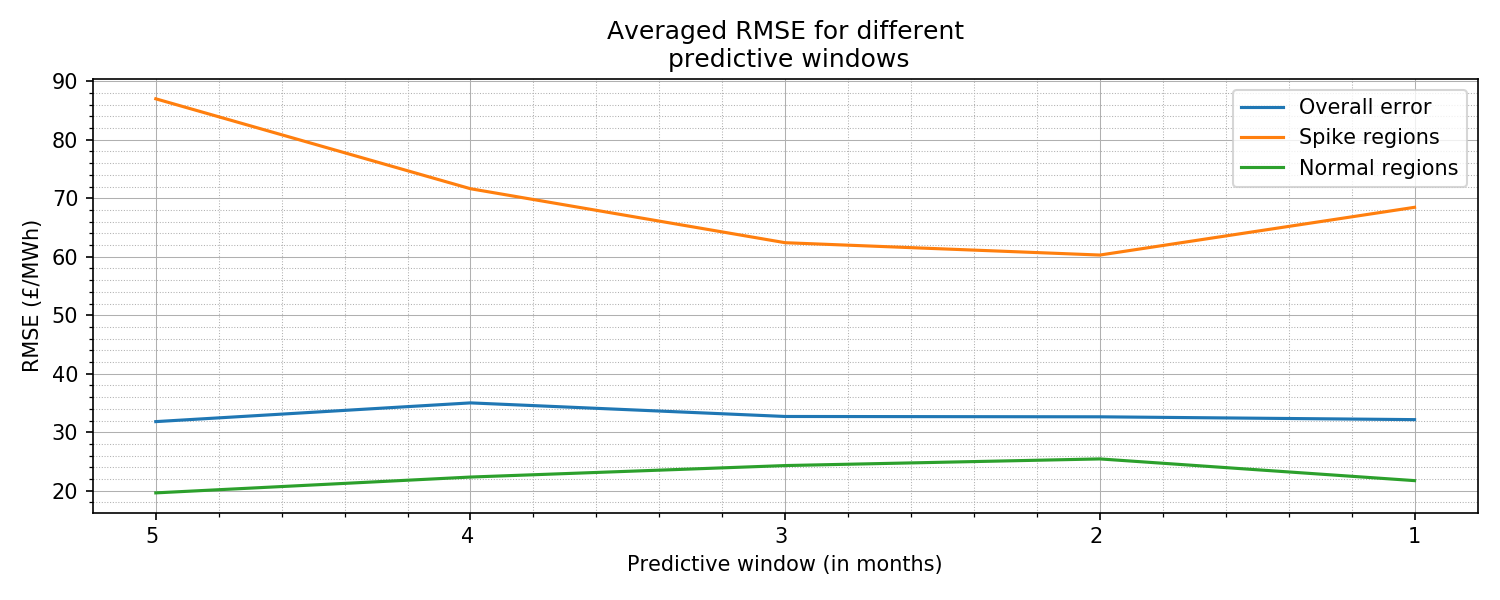

<IPython.core.display.Javascript object>


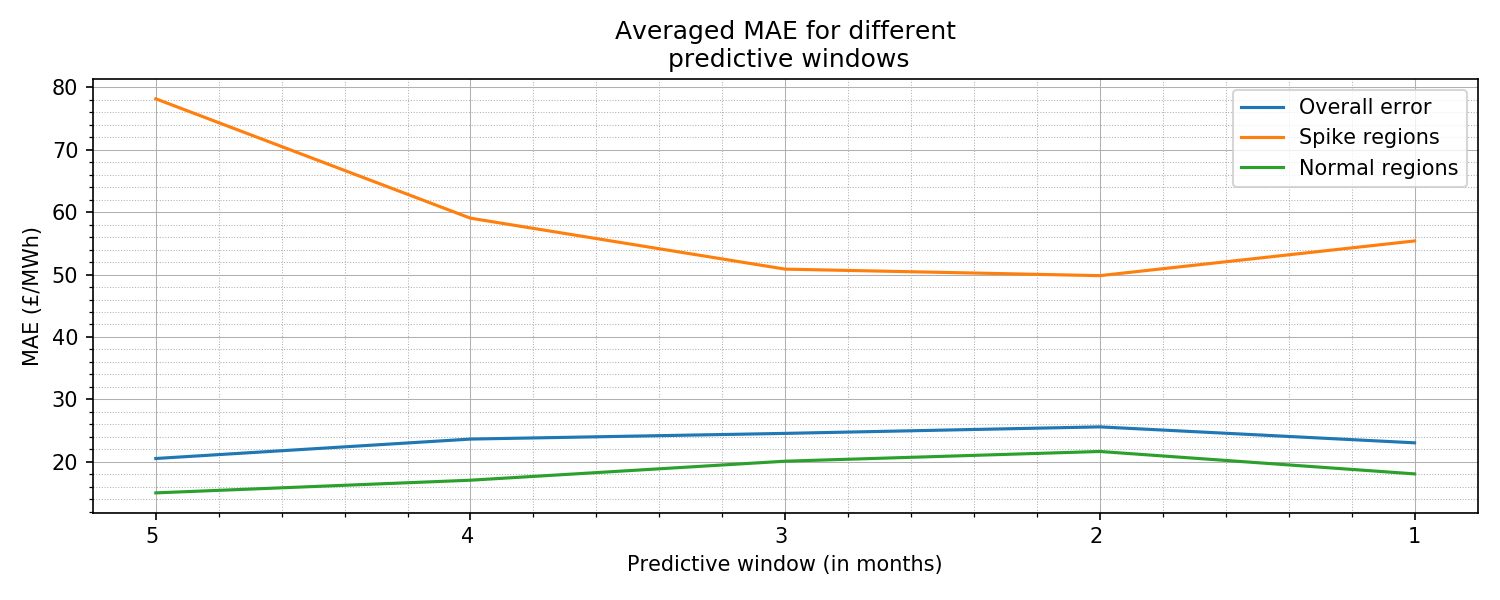

In [11]:
plt.figure(figsize=(10,4))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged RMSE for different\n predictive windows')
rmse_gen_ = [item for item in reversed(rmse_gen)]
rmse_spi_ = [item for item in reversed(rmse_spi)]
rmse_nor_ = [item for item in reversed(rmse_nor)]
plt.plot(rmse_gen_, label = 'Overall error')
plt.plot(rmse_spi_, label = 'Spike regions')
plt.plot(rmse_nor_, label = 'Normal regions')
plt.legend()
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Predictive window (in months)')
out_list = [item for item in reversed(dates_labels)]
dates_labels = out_list
plt.xticks([0,1,2,3,4], dates_labels)
plt.tight_layout()
plt.savefig('RMSE_detailed_predictive_window.png')

plt.figure(figsize=(10,4))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged MAE for different\n predictive windows')
mae_gen_ = [item for item in reversed(mae_gen)]
mae_spi_ = [item for item in reversed(mae_spi)]
mae_nor_ = [item for item in reversed(mae_nor)]
plt.plot(mae_gen_, label = 'Overall error')
plt.plot(mae_spi_, label = 'Spike regions')
plt.plot(mae_nor_, label = 'Normal regions')
plt.legend()
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Predictive window (in months)')
plt.xticks([0,1,2,3,4], dates_labels)
plt.tight_layout()
plt.savefig('MAE_detailed_predictive_window.png')

In [9]:
out_list = [item for item in reversed(dates_labels)]
out_list

['5 ', '4 ', '3 ', '2 ', '1']